Data types in df_rp1:
Stage    object
Jan       int64
Feb       int64
Mar       int64
Apr       int64
May       int64
Jun       int64
Jul       int64
Aug       int64
Sep       int64
Oct       int64
Nov       int64
Dec       int64
Jan.1     int64
Feb.1     int64
Mar.1     int64
Apr.1     int64
May.1     int64
Jun.1     int64
Jul.1     int64
dtype: object

Data types in df_abj:
Stage     object
Apr      float64
May      float64
Jun      float64
Jul      float64
Aug      float64
Sep      float64
Oct      float64
Nov      float64
Dec      float64
Jan      float64
Feb      float64
Mar      float64
Apr.1    float64
May.1    float64
Jun.1    float64
Jul.1    float64
dtype: object

Data types in df_jhb:
Stage     object
Apr      float64
May      float64
Jun      float64
Jul      float64
Aug      float64
Sep      float64
Oct      float64
Nov      float64
Dec        int64
Jan        int64
Feb        int64
Mar        int64
Apr.1      int64
May.1      int64
Jun.1      int64
Jul.1      int64
dtype:

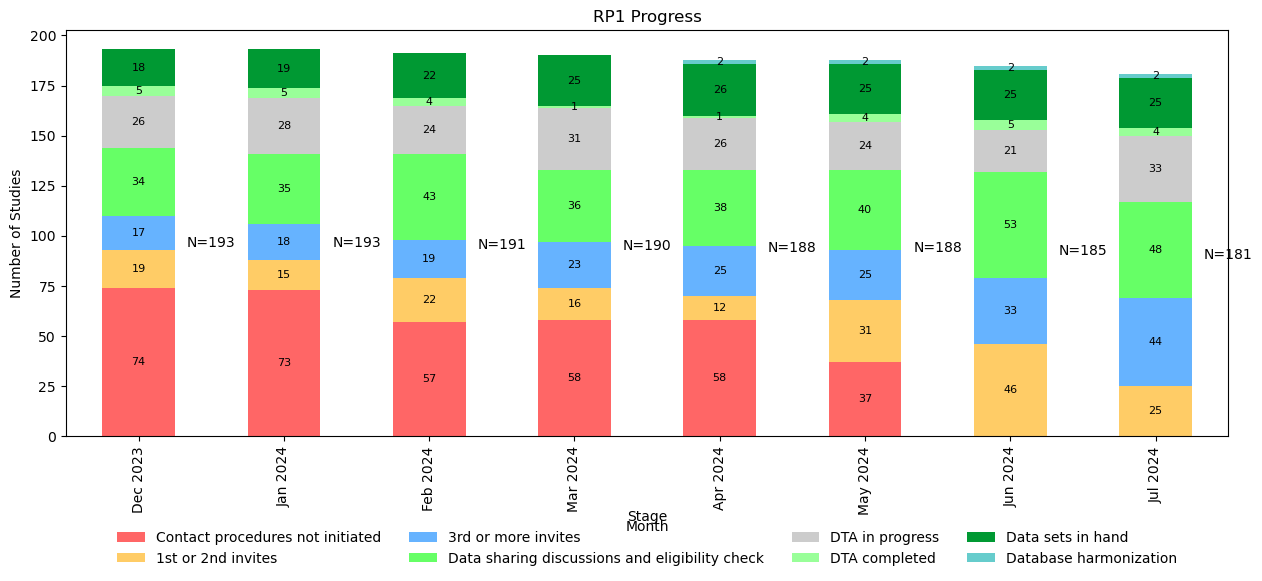

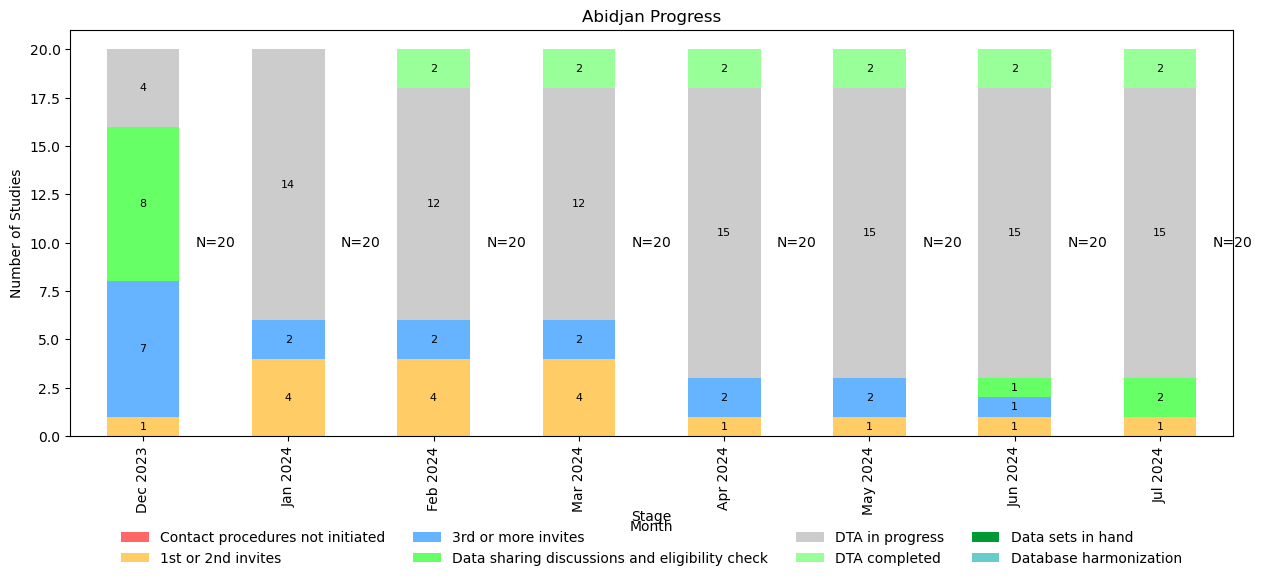

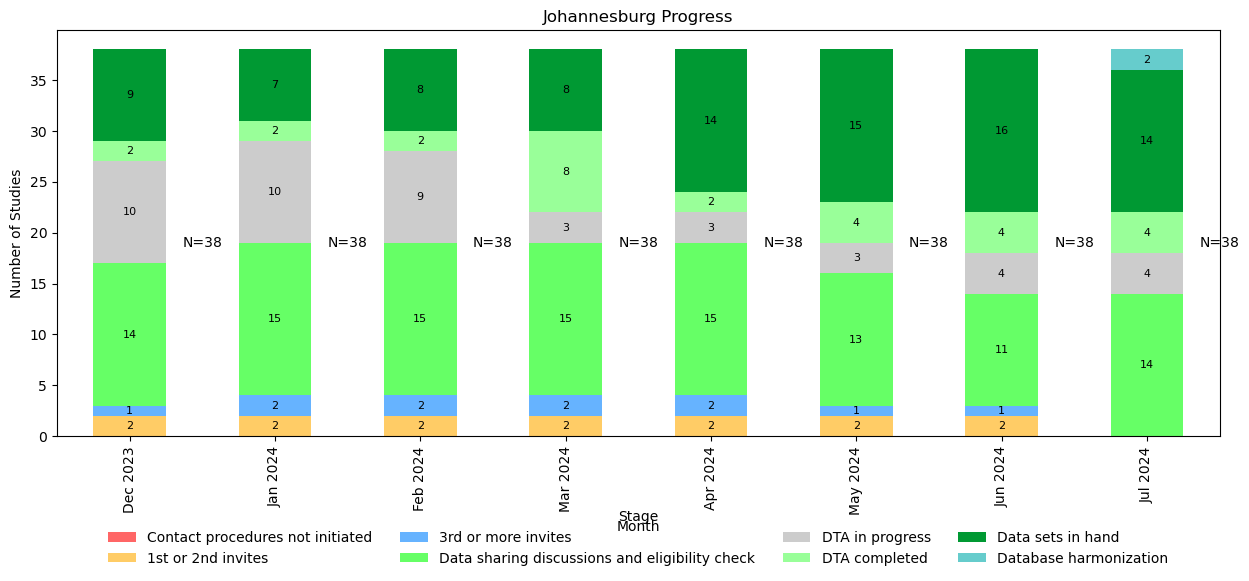

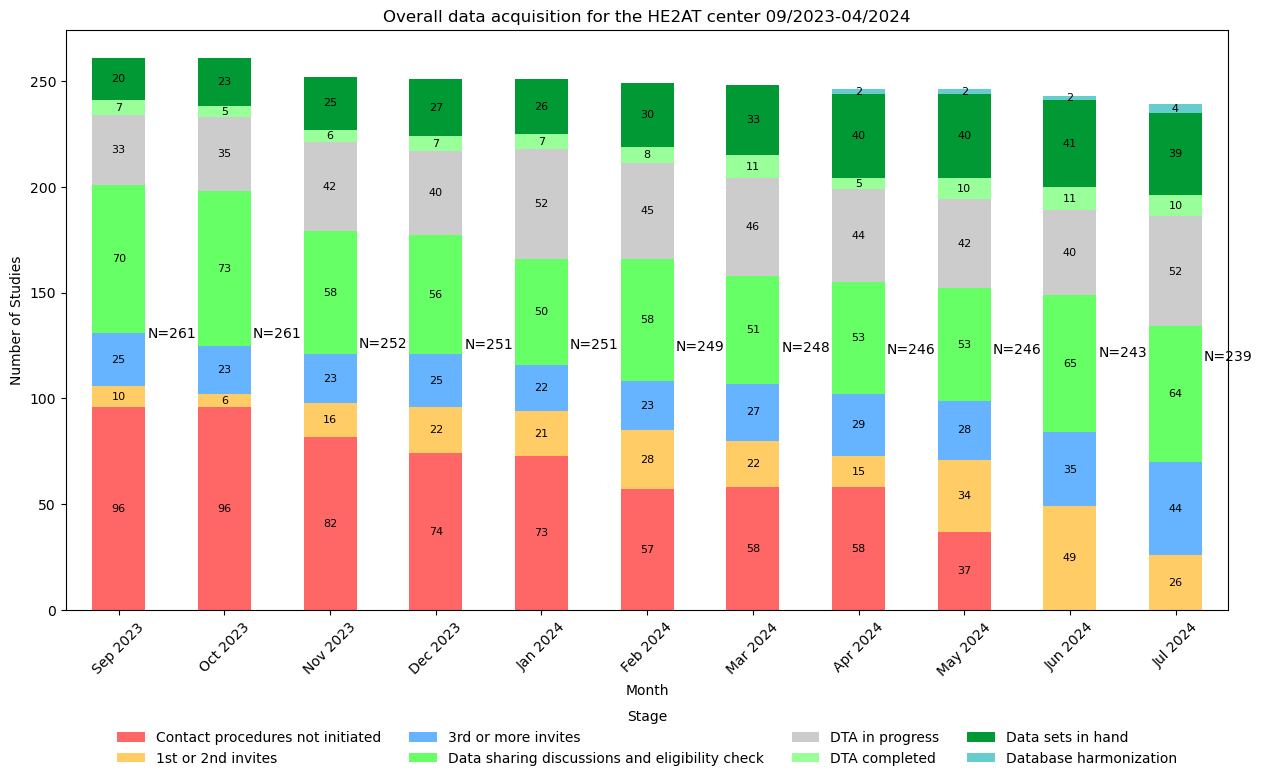

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
xlsx_file = pd.read_excel('HEAT_Tables_0517_am.xlsx', sheet_name=['RP1', 'Abj_outputs', 'Jhb_outputs'])

# Extract each DataFrame from the dictionary
df_rp1 = xlsx_file['RP1']
df_abj = xlsx_file['Abj_outputs']
df_jhb = xlsx_file['Jhb_outputs']

# Print the data types of each DataFrame
print("Data types in df_rp1:")
print(df_rp1.dtypes)
print("\nData types in df_abj:")
print(df_abj.dtypes)
print("\nData types in df_jhb:")
print(df_jhb.dtypes)

# Function to map months and years to columns
def map_month_year(df, start_year=2023):
    month_map = {}
    encountered_dec = False  # Flag to indicate if we've encountered 'Dec'
    months_in_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for column in df.columns:
        if any(month in column for month in months_in_order):
            base_month_name = ''.join(filter(str.isalpha, column))
            if base_month_name == 'Jan' and encountered_dec:
                start_year += 1
            if base_month_name == 'Dec':
                encountered_dec = True
            month_map[column] = f'{base_month_name} {start_year}'
    return df.rename(columns=month_map)

# Convert the month columns in each DataFrame to a datetime format
df_rp1 = map_month_year(df_rp1)
df_abj = map_month_year(df_abj)
df_jhb = map_month_year(df_jhb)

# Print the new column names to verify the changes
print(df_rp1.columns)
print(df_abj.columns)
print(df_jhb.columns)

# Convert column names to datetime
def convert_column_to_datetime(df):
    new_columns = []
    for col in df.columns:
        if col == 'Stage':
            new_columns.append(col)
        else:
            date_str = col.strip() + ' 1'
            new_columns.append(pd.to_datetime(date_str, format='%b %Y %d', errors='coerce'))
    df.columns = new_columns

# Apply the conversion to each dataframe
for dataframe in [df_rp1, df_abj, df_jhb]:
    convert_column_to_datetime(dataframe)

# Check for unique and common stages
stages_rp1 = set(df_rp1['Stage'].tolist())
stages_abj = set(df_abj['Stage'].tolist())
stages_jhb = set(df_jhb['Stage'].tolist())

unique_to_rp1 = stages_rp1.difference(stages_abj).difference(stages_jhb)
unique_to_abj = stages_abj.difference(stages_rp1).difference(stages_jhb)
unique_to_jhb = stages_jhb.difference(stages_rp1).difference(stages_abj)
common_stages = stages_rp1.intersection(stages_abj).intersection(stages_jhb)

print("Stages unique to df_rp1:", unique_to_rp1)
print("Stages unique to df_abj:", unique_to_abj)
print("Stages unique to df_jhb:", unique_to_jhb)
print("Common stages:", common_stages)

if unique_to_rp1 or unique_to_abj or unique_to_jhb:
    print("There are differences in the stage names across the dataframes.")
else:
    print("All stage names are consistent across the dataframes.")

# Define the color map and stage order
color_map = {
    'Contact procedures not initiated': '#ff6666',  # Red
    '1st or 2nd invites': '#ffcc66',  # Orange
    '3rd or more invites': '#66b3ff',  # Light Blue
    'Data sharing discussions and eligibility check': '#66ff66',  # Light Green
    'DTA in progress': '#cccccc',  # Grey
    'DTA completed': '#99ff99',  # Light Green
    'Data sets in hand': '#009933',  # Dark Green
    'Database harmonization': '#66cccc',  # Teal
    'Ineligible/declined participation/data currently unavailable': '#ff9999'  # Pink
}

stage_order = [
    'Contact procedures not initiated',
    '1st or 2nd invites',
    '3rd or more invites',
    'Data sharing discussions and eligibility check',
    'DTA in progress',
    'DTA completed',
    'Data sets in hand',
    'Database harmonization',
    'Ineligible/declined participation/data currently unavailable'
]


# Function to plot the main stacked bar chart
def plot_stacked_bar_chart(df, title, last_n_months=8, color_map=None, stage_order=None):
    df = df.set_index('Stage').reindex(stage_order).fillna(0).reset_index()
    excluded_df = df[df['Stage'] == 'Ineligible/declined participation/data currently unavailable']
    df = df[df['Stage'] != 'Ineligible/declined participation/data currently unavailable']
    stages_df = df[~df['Stage'].str.contains("Total")]
    transposed_df = stages_df.set_index('Stage').transpose()
    transposed_df = transposed_df.iloc[-last_n_months:]

    fig, ax = plt.subplots(figsize=(15, 7))
    bars = transposed_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(x, '#333333') for x in stage_order])

    for i, month in enumerate(transposed_df.index):
        month_data = transposed_df.loc[month]
        cumulative_height = month_data.sum()
        total_height = month_data.sum()
        x_position = i + 0.5
        ax.text(x_position, cumulative_height / 2, f"N={int(cumulative_height)}", ha='center', va='center')

        for j, (stage, value) in enumerate(month_data.items()):
            if value > 0:
                height = sum(month_data[:j+1]) - (value / 2)
                ax.text(i, height, f'{int(value)}', ha='center', va='center', fontsize=8)

    ax.set_xticklabels([x.strftime('%b %Y') for x in transposed_df.index])
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    
    return ax

# Function to overlay excluded studies
def overlay_excluded_studies(ax, excluded_df, transposed_df):
    if not excluded_df.empty:
        excluded_df = excluded_df.drop(columns=['Stage'], errors='ignore')
        excluded_totals = excluded_df.transpose().sum()
        if not excluded_totals.empty:
            for i, month in enumerate(transposed_df.index):
                if month in excluded_totals.index:
                    excluded = excluded_totals[month]
                    if excluded > 0:
                        ax.text(i, transposed_df.loc[month].sum() / 2, f"n={int(excluded)}", ha='center', va='bottom', color='red', fontsize=10, fontweight='bold')

# Plot for each DataFrame
ax_rp1 = plot_stacked_bar_chart(df_rp1, 'RP1 Progress', last_n_months=8, color_map=color_map, stage_order=stage_order)
overlay_excluded_studies(ax_rp1, df_rp1[df_rp1['Stage'] == 'Ineligible/declined participation/data currently unavailable'], df_rp1.set_index('Stage').transpose().iloc[-8:])

ax_abj = plot_stacked_bar_chart(df_abj, 'Abidjan Progress', last_n_months=8, color_map=color_map, stage_order=stage_order)
overlay_excluded_studies(ax_abj, df_abj[df_abj['Stage'] == 'Ineligible/declined participation/data currently unavailable'], df_abj.set_index('Stage').transpose().iloc[-8:])

ax_jhb = plot_stacked_bar_chart(df_jhb, 'Johannesburg Progress', last_n_months=8, color_map=color_map, stage_order=stage_order)
overlay_excluded_studies(ax_jhb, df_jhb[df_jhb['Stage'] == 'Ineligible/declined participation/data currently unavailable'], df_jhb.set_index('Stage').transpose().iloc[-8:])

# Combining and plotting function for multiple dataframes
def combine_and_plot_stacked_bars(dfs, title, start_month=9, start_year=2023, stage_order=None, color_map=None):
    combined_df = pd.DataFrame()
    excluded_df = pd.DataFrame()
    for df in dfs:
        df = df.fillna(0).set_index('Stage').reindex(stage_order).fillna(0)
        if 'Ineligible/declined participation/data currently unavailable' in df.index:
            excluded_df = excluded_df.add(df.loc[['Ineligible/declined participation/data currently unavailable']], fill_value=0)
            df = df.drop(['Ineligible/declined participation/data currently unavailable'])
        combined_df = combined_df.add(df, fill_value=0) if not combined_df.empty else df
    transposed_combined_df = combined_df.transpose()
    transposed_combined_df.index = pd.to_datetime(transposed_combined_df.index)
    start_date = pd.Timestamp(year=start_year, month=start_month, day=1)
    filtered_df = transposed_combined_df[transposed_combined_df.index >= start_date]

    fig, ax = plt.subplots(figsize=(15, 10))
    bars = filtered_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(stage) for stage in stage_order])

    for i, month in enumerate(filtered_df.index):
        month_data = filtered_df.loc[month]
        cumulative_height = month_data.sum()
        total_height = month_data.sum()
        x_position = i + 0.5
        ax.text(x_position, cumulative_height / 2, f"N={int(cumulative_height)}", ha='center', va='center')

        for j, (stage, value) in enumerate(month_data.items()):
            if value > 0:
                height = sum(month_data[:j+1]) - (value / 2)
                ax.text(i, height, f'{int(value)}', ha='center', va='center', fontsize=8)

    ax.set_xticklabels([index.strftime('%b %Y') for index in filtered_df.index], rotation=45)
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    
    overlay_excluded_studies(ax, excluded_df, filtered_df)
    plt.show()

combine_and_plot_stacked_bars(
    [df_rp1, df_abj, df_jhb],
    'Overall data acquisition for the HE2AT center 09/2023-04/2024',
    start_month=9,
    start_year=2023,
    stage_order=stage_order,
    color_map=color_map
)


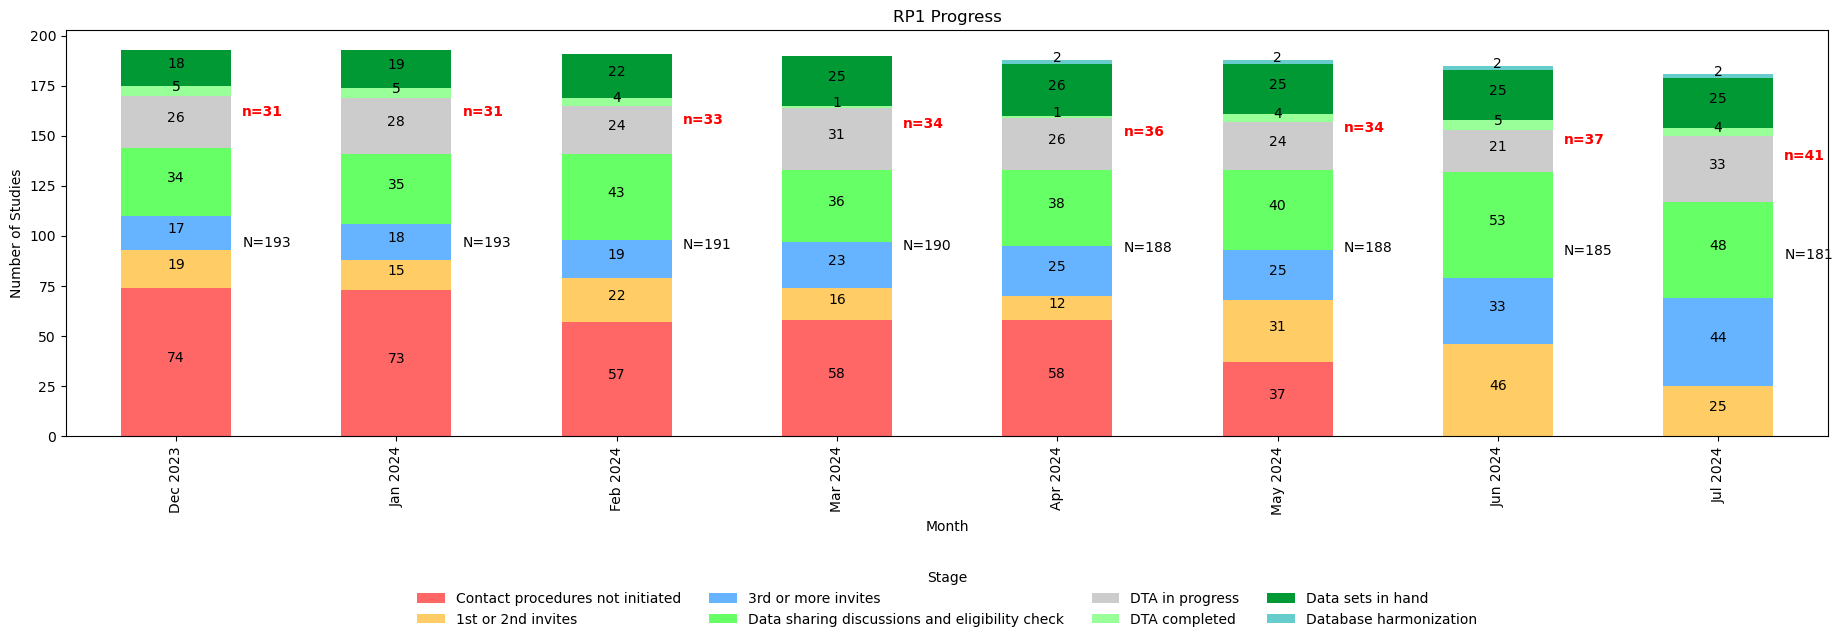

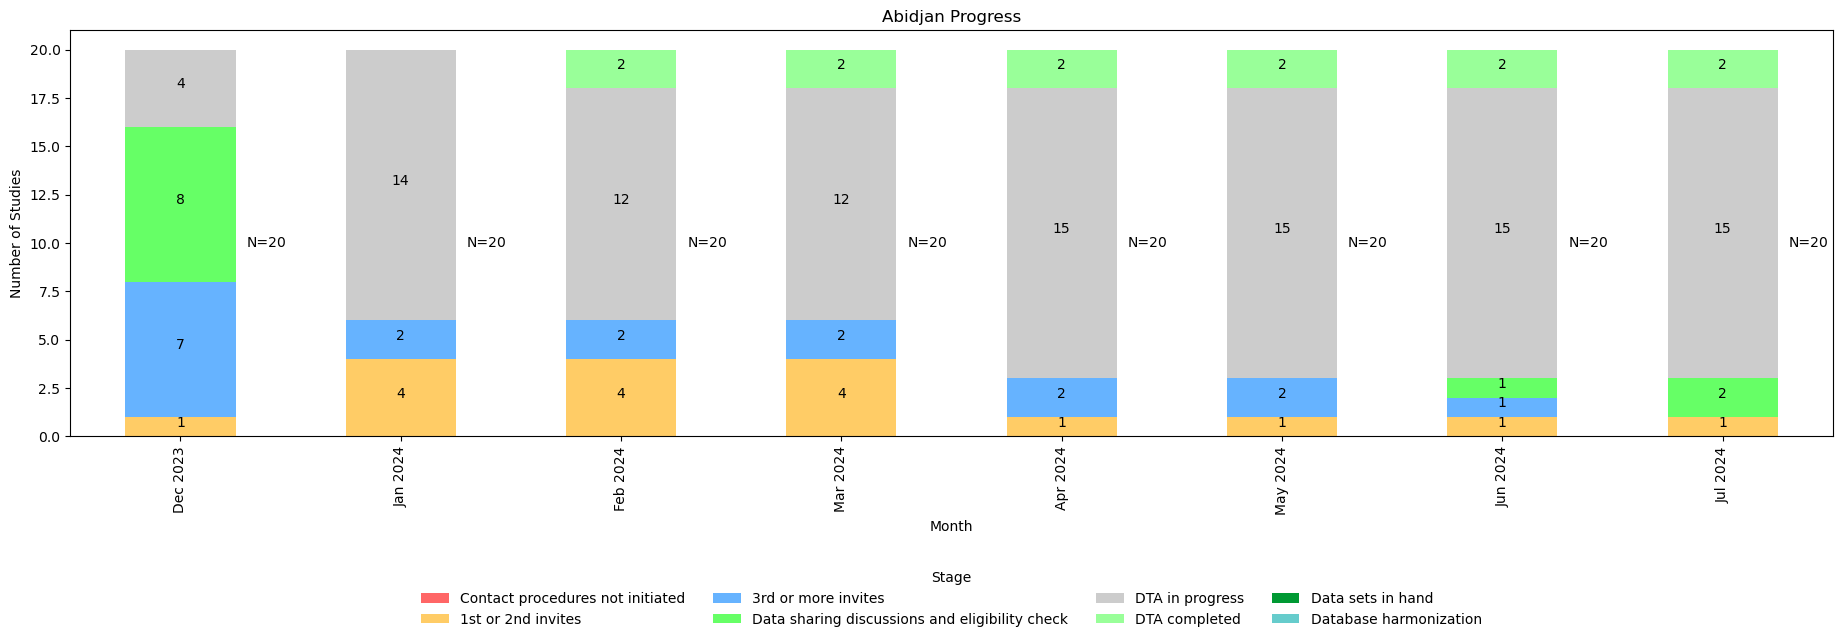

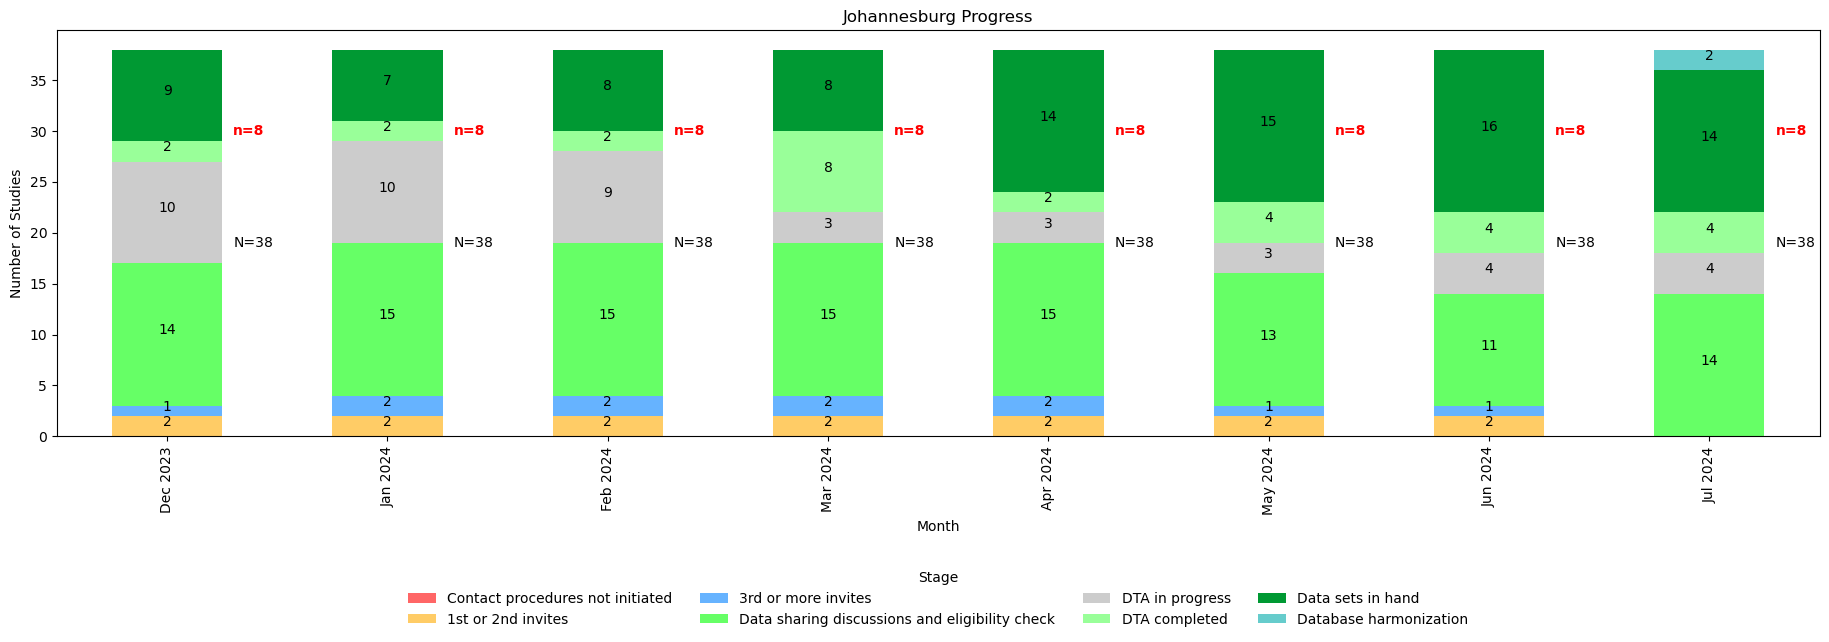

In [2]:
def plot_stacked_bar_chart(df, title, last_n_months=8, color_map=None, stage_order=None):
    df = df.set_index('Stage').reindex(stage_order).reset_index()
    stages_df = df[~df['Stage'].str.contains("Total")]
    transposed_df = stages_df.set_index('Stage').transpose()
    transposed_df = transposed_df.iloc[-last_n_months:]

    # Exclude 'Ineligible/declined participation/data currently unavailable' from the plot
    plot_df = transposed_df.drop(columns=['Ineligible/declined participation/data currently unavailable'], errors='ignore')

    fig, ax = plt.subplots(figsize=(15, 7))
    bars = plot_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(x, '#333333') for x in stage_order if x in plot_df.columns])

    for bar in bars.containers:
        labels = [f'{v.get_height():.0f}' if v.get_height() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3)

    for i, month in enumerate(transposed_df.index):
        month_data = transposed_df.loc[month]
        cumulative_height = float(month_data.drop('Ineligible/declined participation/data currently unavailable', errors='ignore').sum())
        excluded_height = float(month_data.get('Ineligible/declined participation/data currently unavailable', 0))

        x_position = i + 0.5
        # Adjust the positions of the N= and n= labels
        ax.text(i + 0.3, cumulative_height / 2, f"N={cumulative_height:.0f}", ha='left', va='center')
        if excluded_height > 0:
            ax.text(i + 0.3, cumulative_height - (excluded_height), f"n={excluded_height:.0f}", ha='left', va='center', color='red', fontsize=10, fontweight='bold')

    ax.set_xticklabels([x.strftime('%b %Y') for x in transposed_df.index])
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3, right=1.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    plt.show()

# Plot for each DataFrame
plot_stacked_bar_chart(df_rp1, 'RP1 Progress', last_n_months=8, color_map=color_map, stage_order=stage_order)
plot_stacked_bar_chart(df_abj, 'Abidjan Progress', last_n_months=8, color_map=color_map, stage_order=stage_order)
plot_stacked_bar_chart(df_jhb, 'Johannesburg Progress', last_n_months=8, color_map=color_map, stage_order=stage_order)

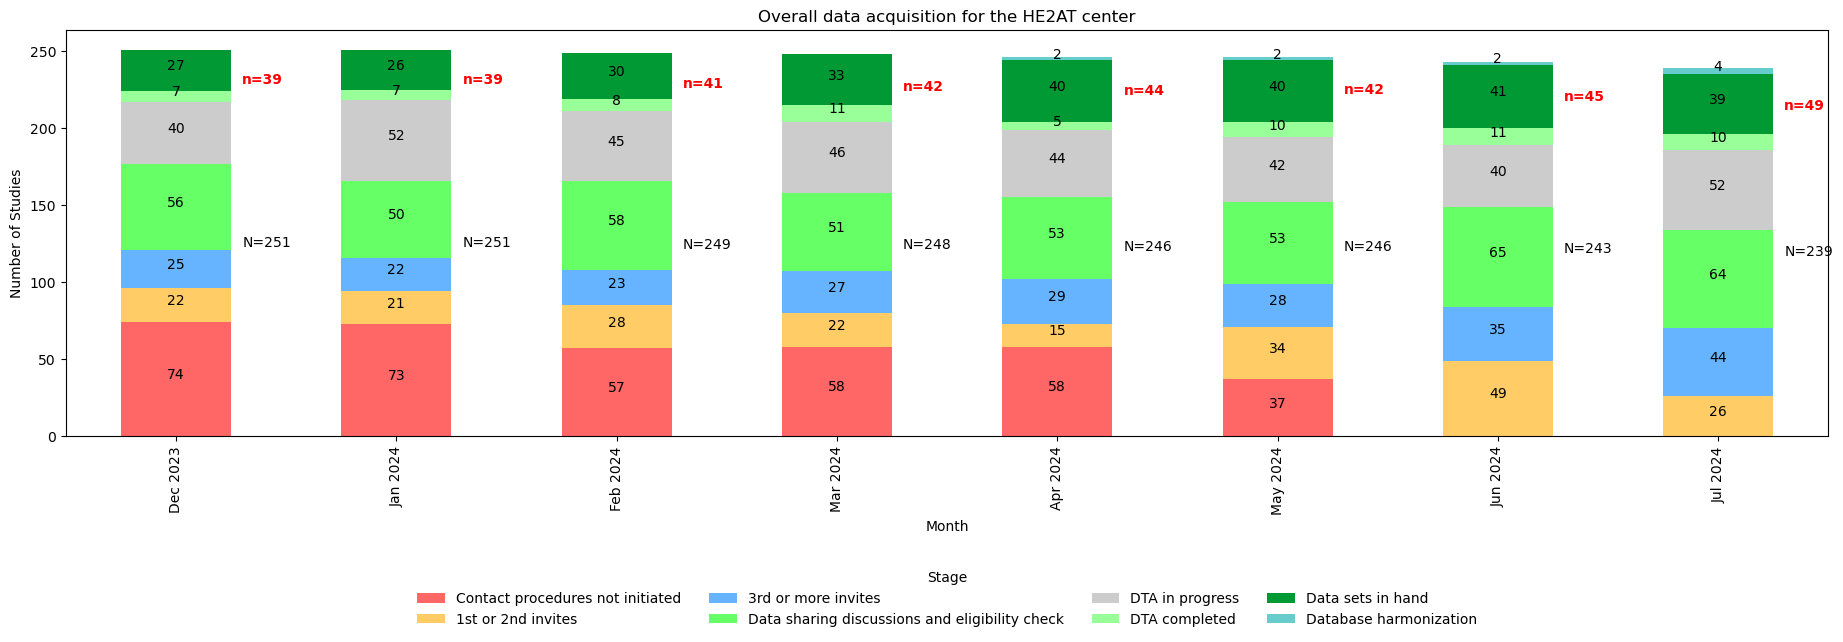

In [3]:
# Function to combine and plot the cumulative stacked bar chart
def plot_cumulative_stacked_bar_chart(dfs, title, last_n_months=8, color_map=None, stage_order=None):
    combined_df = pd.DataFrame()
    for df in dfs:
        df = df.set_index('Stage').reindex(stage_order).reset_index()
        stages_df = df[~df['Stage'].str.contains("Total")]
        if combined_df.empty:
            combined_df = stages_df
        else:
            combined_df = combined_df.set_index('Stage').add(stages_df.set_index('Stage'), fill_value=0).reset_index()
    transposed_df = combined_df.set_index('Stage').transpose()
    transposed_df = transposed_df.iloc[-last_n_months:]

    # Exclude 'Ineligible/declined participation/data currently unavailable' from the plot
    plot_df = transposed_df.drop(columns=['Ineligible/declined participation/data currently unavailable'], errors='ignore')

    fig, ax = plt.subplots(figsize=(15, 7))
    bars = plot_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(x, '#333333') for x in stage_order if x in plot_df.columns])

    for bar in bars.containers:
        labels = [f'{v.get_height():.0f}' if v.get_height() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3)

    for i, month in enumerate(transposed_df.index):
        month_data = transposed_df.loc[month]
        cumulative_height = float(month_data.drop('Ineligible/declined participation/data currently unavailable', errors='ignore').sum())
        excluded_height = float(month_data.get('Ineligible/declined participation/data currently unavailable', 0))

        x_position = i + 0.5
        # Adjust the positions of the N= and n= labels
        ax.text(i + 0.3, cumulative_height / 2, f"N={cumulative_height:.0f}", ha='left', va='center')
        if excluded_height > 0:
            ax.text(i + 0.3, cumulative_height - (excluded_height / 2), f"n={excluded_height:.0f}", ha='left', va='center', color='red', fontsize=10, fontweight='bold')

    ax.set_xticklabels([x.strftime('%b %Y') for x in transposed_df.index])
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3, right=1.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    plt.show()

# Plot the cumulative graph
plot_cumulative_stacked_bar_chart(
    [df_rp1, df_abj, df_jhb],
    'Overall data acquisition for the HE2AT center',
    last_n_months=8,
    color_map=color_map,
    stage_order=stage_order
)

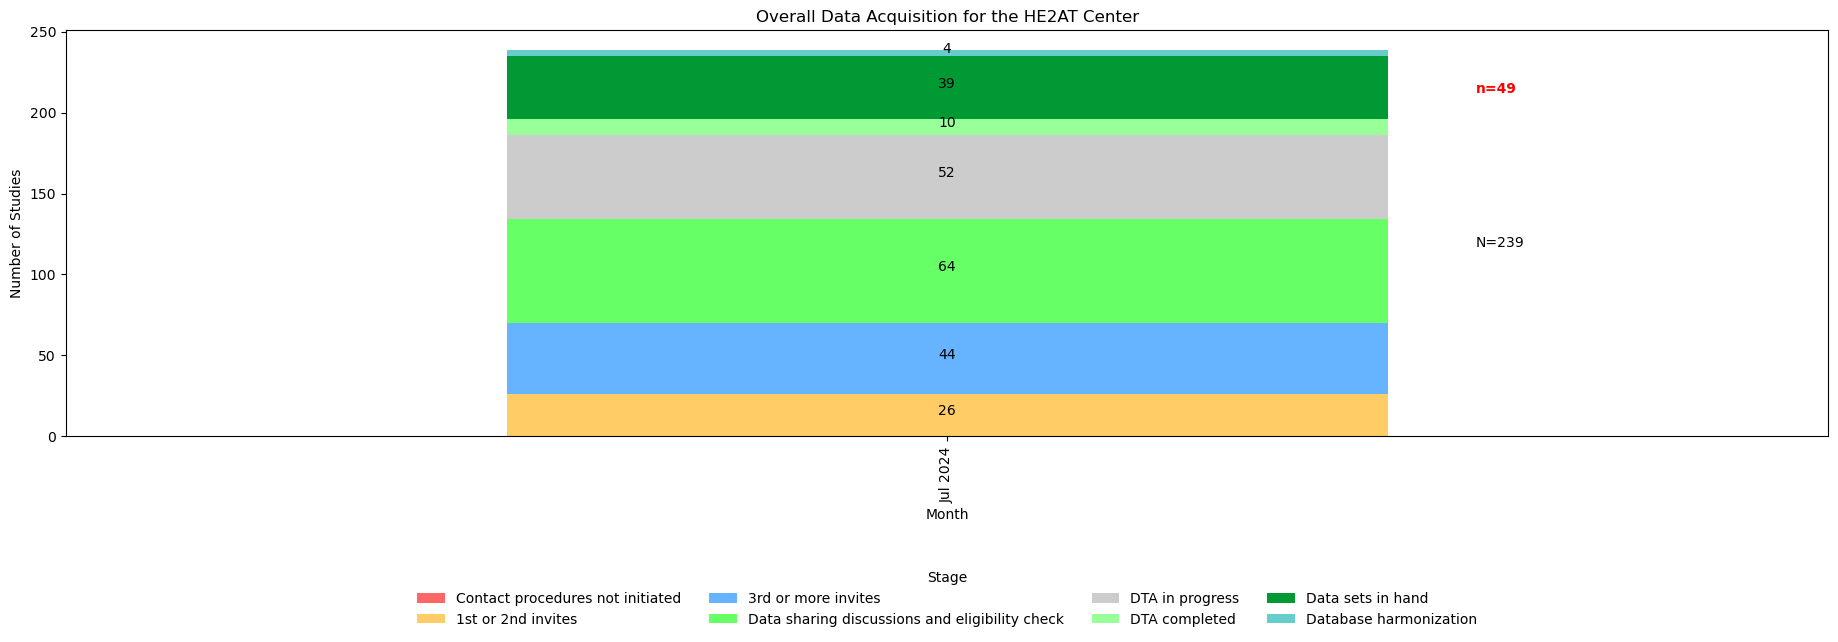

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to combine and plot the cumulative stacked bar chart
def plot_cumulative_stacked_bar_chart(dfs, title, last_n_months=1, color_map=None, stage_order=None):
    combined_df = pd.DataFrame()
    for df in dfs:
        df = df.set_index('Stage').reindex(stage_order).reset_index()
        stages_df = df[~df['Stage'].str.contains("Total")]
        if combined_df.empty:
            combined_df = stages_df
        else:
            combined_df = combined_df.set_index('Stage').add(stages_df.set_index('Stage'), fill_value=0).reset_index()
    transposed_df = combined_df.set_index('Stage').transpose()
    transposed_df = transposed_df.iloc[-last_n_months:]

    # Exclude 'Ineligible/declined participation/data currently unavailable' from the plot
    plot_df = transposed_df.drop(columns=['Ineligible/declined participation/data currently unavailable'], errors='ignore')

    fig, ax = plt.subplots(figsize=(15, 7))
    bars = plot_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(x, '#333333') for x in stage_order if x in plot_df.columns])

    for bar in bars.containers:
        labels = [f'{v.get_height():.0f}' if v.get_height() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3)

    for i, month in enumerate(transposed_df.index):
        month_data = transposed_df.loc[month]
        cumulative_height = float(month_data.drop('Ineligible/declined participation/data currently unavailable', errors='ignore').sum())
        excluded_height = float(month_data.get('Ineligible/declined participation/data currently unavailable', 0))

        x_position = i + 0.5
        # Adjust the positions of the N= and n= labels
        ax.text(i + 0.3, cumulative_height / 2, f"N={cumulative_height:.0f}", ha='left', va='center')
        if excluded_height > 0:
            ax.text(i + 0.3, cumulative_height - (excluded_height / 2), f"n={excluded_height:.0f}", ha='left', va='center', color='red', fontsize=10, fontweight='bold')

    ax.set_xticklabels([x.strftime('%b %Y') for x in transposed_df.index])
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3, right=1.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    plt.show()

# Plot the cumulative graph
plot_cumulative_stacked_bar_chart(
    [df_rp1, df_abj, df_jhb],
    'Overall Data Acquisition for the HE2AT Center',
    last_n_months=1,
    color_map=color_map,
    stage_order=stage_order
)


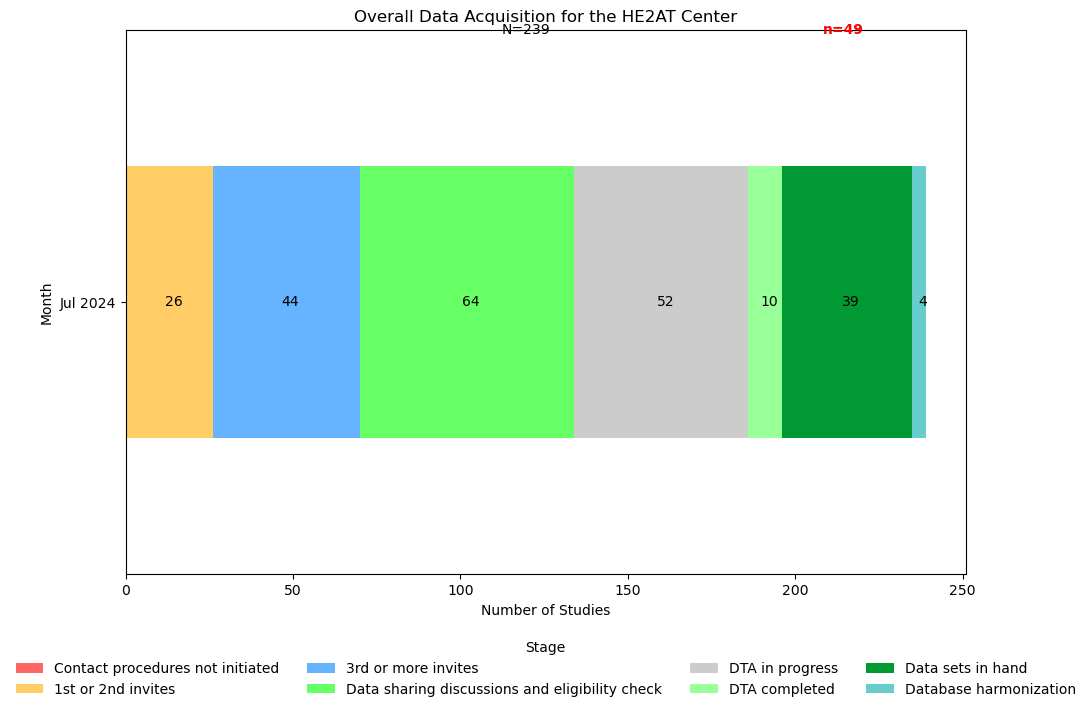

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to combine and plot the cumulative stacked bar chart
def plot_cumulative_stacked_bar_chart(dfs, title, last_n_months=1, color_map=None, stage_order=None):
    combined_df = pd.DataFrame()
    for df in dfs:
        df = df.set_index('Stage').reindex(stage_order).reset_index()
        stages_df = df[~df['Stage'].str.contains("Total")]
        if combined_df.empty:
            combined_df = stages_df
        else:
            combined_df = combined_df.set_index('Stage').add(stages_df.set_index('Stage'), fill_value=0).reset_index()
    transposed_df = combined_df.set_index('Stage').transpose()
    transposed_df = transposed_df.iloc[-last_n_months:]

    # Exclude 'Ineligible/declined participation/data currently unavailable' from the plot
    plot_df = transposed_df.drop(columns=['Ineligible/declined participation/data currently unavailable'], errors='ignore')

    fig, ax = plt.subplots(figsize=(12, 8))  # Adjusted figure size for a longer bar
    bars = plot_df.plot(kind='barh', stacked=True, ax=ax, color=[color_map.get(x, '#333333') for x in stage_order if x in plot_df.columns])

    for bar in bars.containers:
        labels = [f'{v.get_width():.0f}' if v.get_width() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3)

    for i, month in enumerate(transposed_df.index):
        month_data = transposed_df.loc[month]
        cumulative_width = float(month_data.drop('Ineligible/declined participation/data currently unavailable', errors='ignore').sum())
        excluded_width = float(month_data.get('Ineligible/declined participation/data currently unavailable', 0))

        y_position = i + 0.5
        # Adjust the positions of the N= and n= labels
        ax.text(cumulative_width / 2, y_position, f"N={cumulative_width:.0f}", ha='center', va='center')
        if excluded_width > 0:
            ax.text(cumulative_width - (excluded_width / 2), y_position, f"n={excluded_width:.0f}", ha='center', va='center', color='red', fontsize=10, fontweight='bold')

    ax.set_yticklabels([x.strftime('%b %Y') for x in transposed_df.index])
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(left=0.15, bottom=0.2, right=0.85)
    ax.set_title(title)
    ax.set_ylabel('Month')
    ax.set_xlabel('Number of Studies')
    plt.show()

# Plot the cumulative graph
plot_cumulative_stacked_bar_chart(
    [df_rp1, df_abj, df_jhb],
    'Overall Data Acquisition for the HE2AT Center',
    last_n_months=1,
    color_map=color_map,
    stage_order=stage_order
)


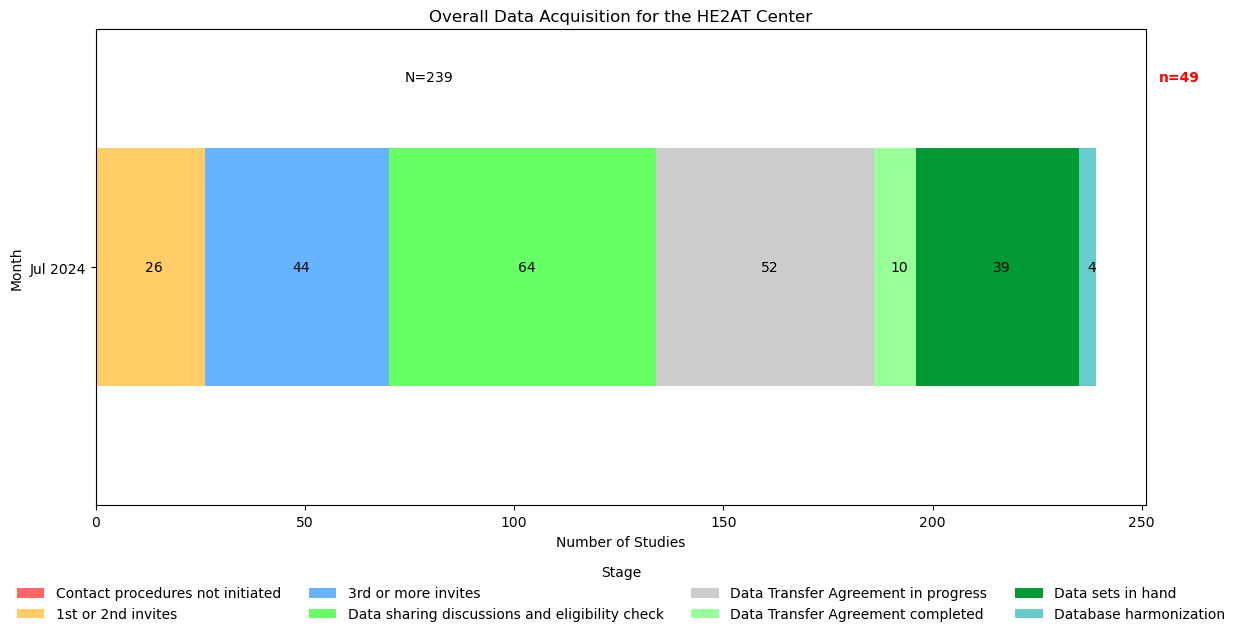

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to combine and plot the cumulative stacked bar chart
def plot_cumulative_stacked_bar_chart(dfs, title, last_n_months=1, color_map=None, stage_order=None):
    combined_df = pd.DataFrame()
    for df in dfs:
        df = df.set_index('Stage').reindex(stage_order).reset_index()
        stages_df = df[~df['Stage'].str.contains("Total")]
        if combined_df.empty:
            combined_df = stages_df
        else:
            combined_df = combined_df.set_index('Stage').add(stages_df.set_index('Stage'), fill_value=0).reset_index()
    transposed_df = combined_df.set_index('Stage').transpose()
    transposed_df = transposed_df.iloc[-last_n_months:]

    # Exclude 'Ineligible/declined participation/data currently unavailable' from the plot
    plot_df = transposed_df.drop(columns=['Ineligible/declined participation/data currently unavailable'], errors='ignore')

    fig, ax = plt.subplots(figsize=(15, 7))  # Adjusted figure size for a longer bar
    bars = plot_df.plot(kind='barh', stacked=True, ax=ax, color=[color_map.get(x, '#333333') for x in stage_order if x in plot_df.columns])

    for bar in bars.containers:
        labels = [f'{v.get_width():.0f}' if v.get_width() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3)

    for i, month in enumerate(transposed_df.index):
        month_data = transposed_df.loc[month]
        cumulative_width = float(month_data.drop('Ineligible/declined participation/data currently unavailable', errors='ignore').sum())
        excluded_width = float(month_data.get('Ineligible/declined participation/data currently unavailable', 0))

        y_position = i + 0.4
        # Adjust the positions of the N= and n= labels
        ax.text(cumulative_width / 3, y_position, f"N={cumulative_width:.0f}", ha='center', va='center')
        if excluded_width > 0:
            ax.text(cumulative_width + 15, y_position, f"n={excluded_width:.0f}", ha='left', va='center', color='red', fontsize=10, fontweight='bold')

    ax.set_yticklabels([x.strftime('%b %Y') for x in transposed_df.index])
    legend_labels = ['Contact procedures not initiated', '1st or 2nd invites', '3rd or more invites', 'Data sharing discussions and eligibility check', 'Data Transfer Agreement in progress', 'Data Transfer Agreement completed', 'Data sets in hand', 'Database harmonization']
    ax.legend(title='Stage', labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(left=0.15, bottom=0.2, right=0.85)
    ax.set_title(title)
    ax.set_ylabel('Month')
    ax.set_xlabel('Number of Studies')
    plt.show()

# Assuming df_rp1, df_abj, df_jhb, color_map, stage_order are already defined
plot_cumulative_stacked_bar_chart(
    [df_rp1, df_abj, df_jhb],
    'Overall Data Acquisition for the HE2AT Center',
    last_n_months=1,
    color_map=color_map,
    stage_order=stage_order
)


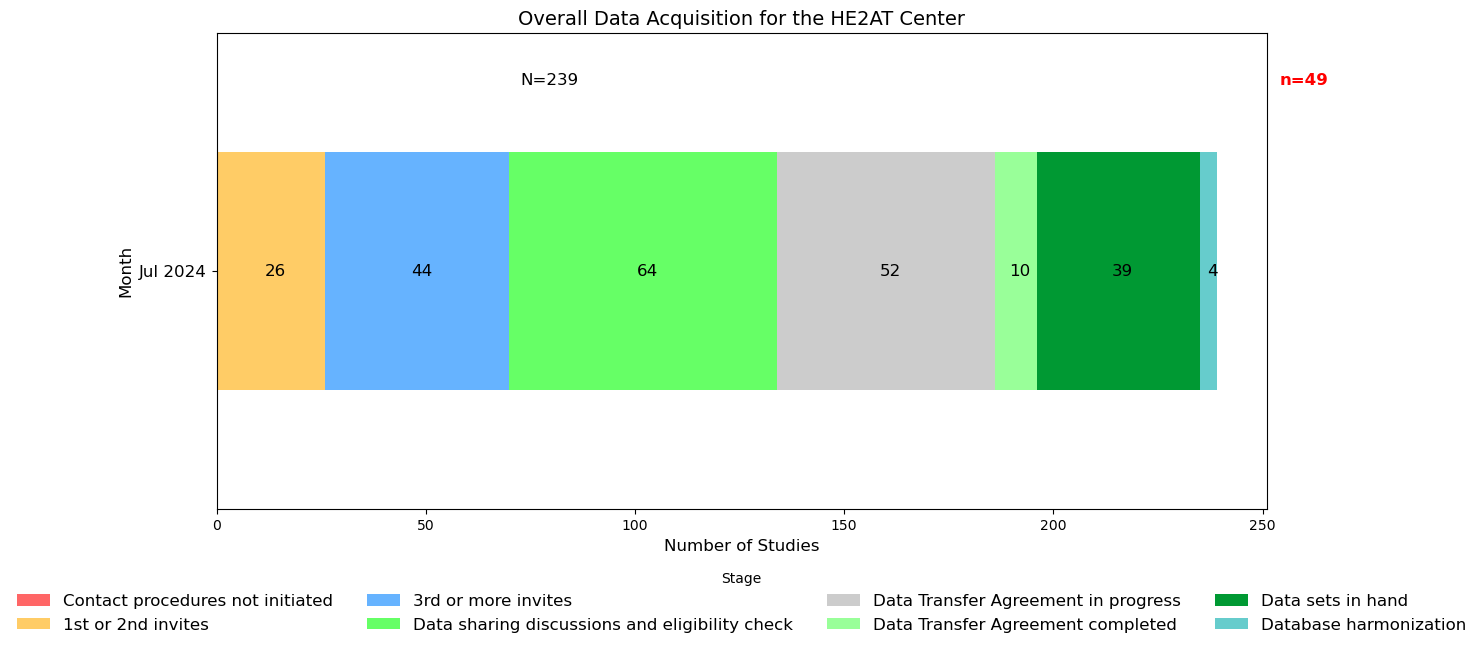

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to combine and plot the cumulative stacked bar chart
def plot_cumulative_stacked_bar_chart(dfs, title, last_n_months=1, color_map=None, stage_order=None):
    combined_df = pd.DataFrame()
    for df in dfs:
        df = df.set_index('Stage').reindex(stage_order).reset_index()
        stages_df = df[~df['Stage'].str.contains("Total")]
        if combined_df.empty:
            combined_df = stages_df
        else:
            combined_df = combined_df.set_index('Stage').add(stages_df.set_index('Stage'), fill_value=0).reset_index()
    transposed_df = combined_df.set_index('Stage').transpose()
    transposed_df = transposed_df.iloc[-last_n_months:]

    # Exclude 'Ineligible/declined participation/data currently unavailable' from the plot
    plot_df = transposed_df.drop(columns=['Ineligible/declined participation/data currently unavailable'], errors='ignore')

    fig, ax = plt.subplots(figsize=(15, 7))  # Adjusted figure size for a longer bar
    bars = plot_df.plot(kind='barh', stacked=True, ax=ax, color=[color_map.get(x, '#333333') for x in stage_order if x in plot_df.columns])

    for bar in bars.containers:
        labels = [f'{v.get_width():.0f}' if v.get_width() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3, fontsize=12)  # Increased font size

    for i, month in enumerate(transposed_df.index):
        month_data = transposed_df.loc[month]
        cumulative_width = float(month_data.drop('Ineligible/declined participation/data currently unavailable', errors='ignore').sum())
        excluded_width = float(month_data.get('Ineligible/declined participation/data currently unavailable', 0))

        y_position = i + 0.4
        # Adjust the positions of the N= and n= labels
        ax.text(cumulative_width / 3, y_position, f"N={cumulative_width:.0f}", ha='center', va='center', fontsize=12)  # Increased font size
        if excluded_width > 0:
            ax.text(cumulative_width + 15, y_position, f"n={excluded_width:.0f}", ha='left', va='center', color='red', fontsize=12, fontweight='bold')  # Increased font size

    ax.set_yticklabels([x.strftime('%b %Y') for x in transposed_df.index], fontsize=12)  # Increased font size
    ax.set_xlabel('Number of Studies', fontsize=12)  # Increased font size
    ax.set_ylabel('Month', fontsize=12)  # Increased font size
    ax.set_title(title, fontsize=14)  # Increased font size
    legend_labels = ['Contact procedures not initiated', '1st or 2nd invites', '3rd or more invites', 'Data sharing discussions and eligibility check', 'Data Transfer Agreement in progress', 'Data Transfer Agreement completed', 'Data sets in hand', 'Database harmonization']
    ax.legend(title='Stage', labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(stage_order)//2, frameon=False, fontsize=12)  # Increased font size
    plt.subplots_adjust(left=0.15, bottom=0.2, right=0.85)
    plt.show()

# Assuming df_rp1, df_abj, df_jhb, color_map, stage_order are already defined
plot_cumulative_stacked_bar_chart(
    [df_rp1, df_abj, df_jhb],
    'Overall Data Acquisition for the HE2AT Center',
    last_n_months=1,
    color_map=color_map,
    stage_order=stage_order
)


In [4]:
import pandas as pd



# Create a DataFrame from the data
df_rp1_countries = pd.read_excel('HEAT_Tables_0517_am.xlsx', sheet_name='RP1_Countries')

# Calculate the total number of studies for each country
df_rp1_countries['Total Studies'] = df_rp1_countries.drop('Study site', axis=1).sum(axis=1)

# Create a formatted output for each country
df_rp1_countries['Formatted'] = df_rp1_countries['Study site'] + " (n=" + df_rp1_countries['Total Studies'].astype(str) + ")"
formatted_output = df_rp1_countries[['Study site', 'Formatted']].set_index('Study site')

# Print the formatted summary
print(formatted_output)


                          Formatted
Study site                         
Benin                   Benin (n=4)
Botswana             Botswana (n=2)
Burkina Faso     Burkina Faso (n=4)
Cameroon             Cameroon (n=2)
Côte d'Ivoire   Côte d'Ivoire (n=1)
DRC                       DRC (n=3)
Ethiopia            Ethiopia (n=19)
Gambia                 Gambia (n=1)
Ghana                  Ghana (n=10)
Kenya                  Kenya (n=17)
Lesotho               Lesotho (n=2)
Malawi                Malawi (n=19)
Mali                     Mali (n=2)
Mozambique         Mozambique (n=3)
Multi-country  Multi-country (n=40)
Nigeria               Nigeria (n=9)
Rwanda                 Rwanda (n=2)
Senegal               Senegal (n=1)
Sierra Leone     Sierra Leone (n=1)
South Africa    South Africa (n=31)
Tanzania            Tanzania (n=22)
Uganda                Uganda (n=17)
Zimbabwe             Zimbabwe (n=4)


Index(['Study site', 'TOTAL'], dtype='object')
Total studies by country:
Study site
Benin             4
Botswana          2
Burkina Faso      4
Cameroon          2
Côte d'Ivoire     1
DRC               3
Ethiopia         19
Gambia            1
Ghana            10
Kenya            17
Lesotho           2
Malawi           19
Mali              2
Mozambique        3
Multi-country    40
Nigeria           9
Rwanda            2
Senegal           1
Sierra Leone      1
South Africa     31
Tanzania         22
Uganda           17
Zimbabwe          4
Name: TOTAL, dtype: int64


C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\4099490806.py:23: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\4099490806.py:78: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_geom = sub_saharan_africa[sub_saharan_africa['iso_a3'] == country].geometry.centroid
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\4099490806.py:78: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_geom = sub_sa

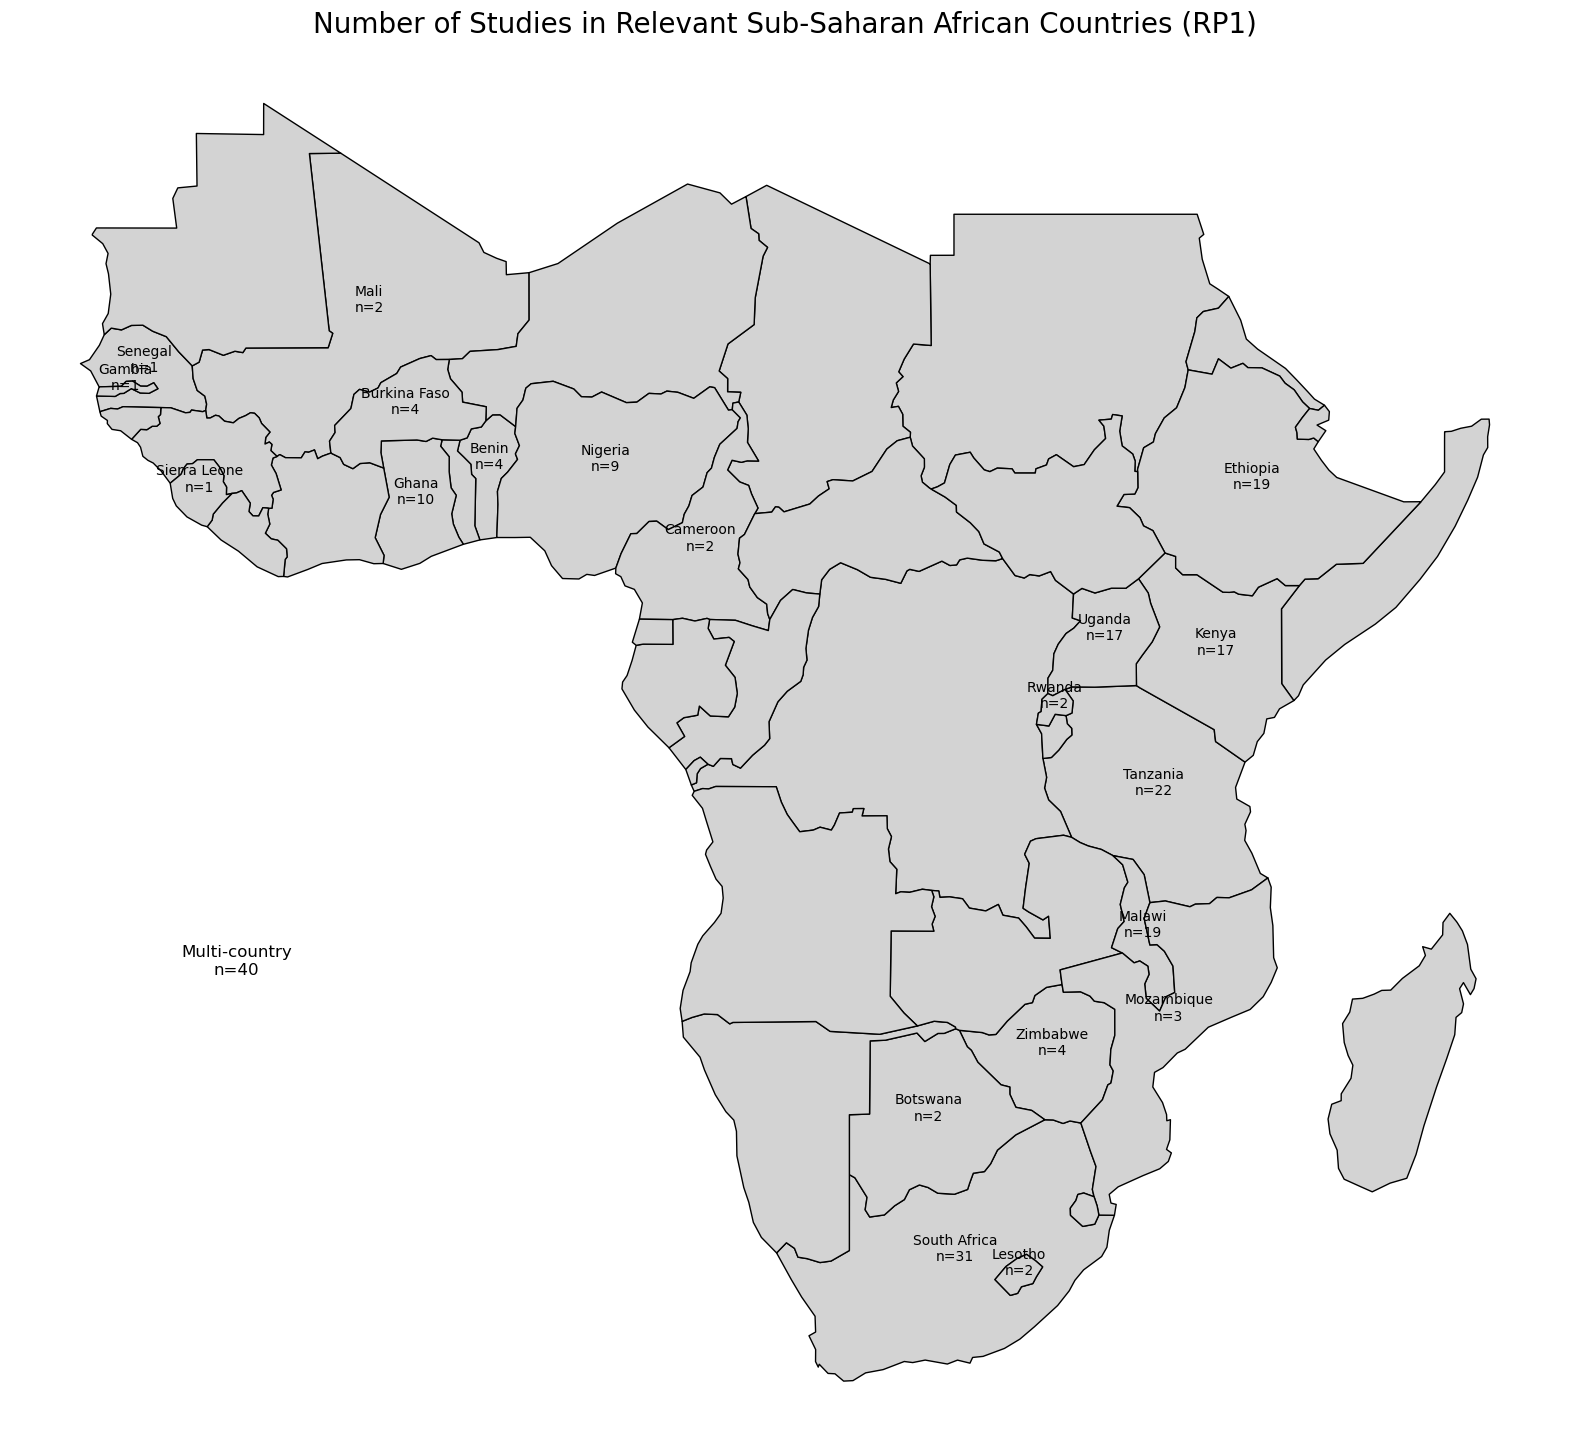

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Load the data from the Excel file
file_path = 'HEAT_Tables_0517_am.xlsx'
df_rp1_countries = pd.read_excel(file_path, sheet_name='RP1_Countries')

# Print the column names to inspect them
print(df_rp1_countries.columns)

# Set the 'Study site' column as the index
df_rp1_countries.set_index('Study site', inplace=True)

# Ensure the 'TOTAL' column is correctly identified
if 'TOTAL' not in df_rp1_countries.columns:
    print("Error: 'TOTAL' column not found in the data.")
else:
    print("Total studies by country:")
    print(df_rp1_countries['TOTAL'])

# Load a map of Africa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = world[(world['continent'] == 'Africa') & (world['name'] != 'Antarctica')]

# Adjust names for compatibility using ISO 3166-1 alpha-3 codes
name_adjustments = {
    "Benin": "BEN",
    "Botswana": "BWA",
    "Burkina Faso": "BFA",
    "Cameroon": "CMR",
    "Cote d'Ivoire": "CIV",
    "Democratic Republic of the Congo": "COD",
    "Congo": "COG",
    "Eswatini": "SWZ",
    "Ethiopia": "ETH",
    "Gambia": "GMB",
    "Ghana": "GHA",
    "Ivory Coast": "CIV",
    "Kenya": "KEN",
    "Lesotho": "LSO",
    "Malawi": "MWI",
    "Mali": "MLI",
    "Mozambique": "MOZ",
    "Nigeria": "NGA",
    "Rwanda": "RWA",
    "Senegal": "SEN",
    "Sierra Leone": "SLE",
    "South Africa": "ZAF",
    "Tanzania": "TZA",
    "Uganda": "UGA",
    "Zimbabwe": "ZWE",
    "Multi-country": "Multi-country"
}

df_rp1_countries.rename(index=name_adjustments, inplace=True)

# Subset the map to Sub-Saharan Africa
sub_saharan_countries = [
    "AGO", "BEN", "BWA", "BFA", "BDI", "CPV", "CMR", 
    "CAF", "TCD", "COM", "COG", "CIV", "DJI", 
    "GNQ", "ERI", "SWZ", "ETH", "GAB", "GMB", "GHA", 
    "GIN", "GNB", "KEN", "LSO", "LBR", "MDG", "MWI", "MLI", 
    "MRT", "MUS", "MOZ", "NAM", "NER", "NGA", "RWA", "STP", 
    "SEN", "SYC", "SLE", "SOM", "ZAF", "SSD", "SDN", 
    "TZA", "TGO", "UGA", "ZMB", "ZWE", "COD"
]
sub_saharan_africa = africa[africa['iso_a3'].isin(sub_saharan_countries)]

# Plot the map of Sub-Saharan Africa
fig, ax = plt.subplots(figsize=(20, 20))
sub_saharan_africa.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot total studies for each country
for country in df_rp1_countries.index:
    if country in sub_saharan_africa['iso_a3'].values:
        total_studies = int(df_rp1_countries.loc[country, 'TOTAL'])
        country_geom = sub_saharan_africa[sub_saharan_africa['iso_a3'] == country].geometry.centroid
        ax.text(country_geom.x.values[0], country_geom.y.values[0], f"{sub_saharan_africa[sub_saharan_africa['iso_a3'] == country]['name'].values[0]}\nn={total_studies}", fontsize=10, ha='center')

# Plot total studies for Multi-country
multi_country_total = int(df_rp1_countries.loc['Multi-country', 'TOTAL'])
ax.text(-10, -15, f"Multi-country\nn={multi_country_total}", fontsize=12, ha='center')

# Add title
plt.title('Number of Studies in Relevant Sub-Saharan African Countries (RP1)', fontsize=20)

# Remove axes
ax.axis('off')

plt.show()


Index(['Study site', 'TOTAL', '1st invite', '2nd invite', '3rd or more invite',
       'Interested', 'Follow up on interest', 'Study documents received',
       'Eligibility confirmed', 'Entering DTA', 'DTA complete', 'Ineligible',
       'Declined participation', 'Data unavailable'],
      dtype='object')
Total studies by country:
Study site
Benin             4
Botswana          2
Burkina Faso      4
Cameroon          2
Cote d'Ivoire     1
Congo             3
Ethiopia         19
Gambia            1
Ghana            10
Kenya            17
Lesotho           2
Malawi           19
Mali              2
Mozambique        3
Multi-country    40
Nigeria           9
Rwanda            2
Senegal           1
Sierra Leone      1
South Africa     31
Tanzania         22
Uganda           17
Zimbabwe          4
Name: TOTAL, dtype: int64


C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\1386982603.py:23: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\1386982603.py:78: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_geom = sub_saharan_africa[sub_saharan_africa['iso_a3'] == country].geometry.centroid
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\1386982603.py:78: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_geom = sub_sa

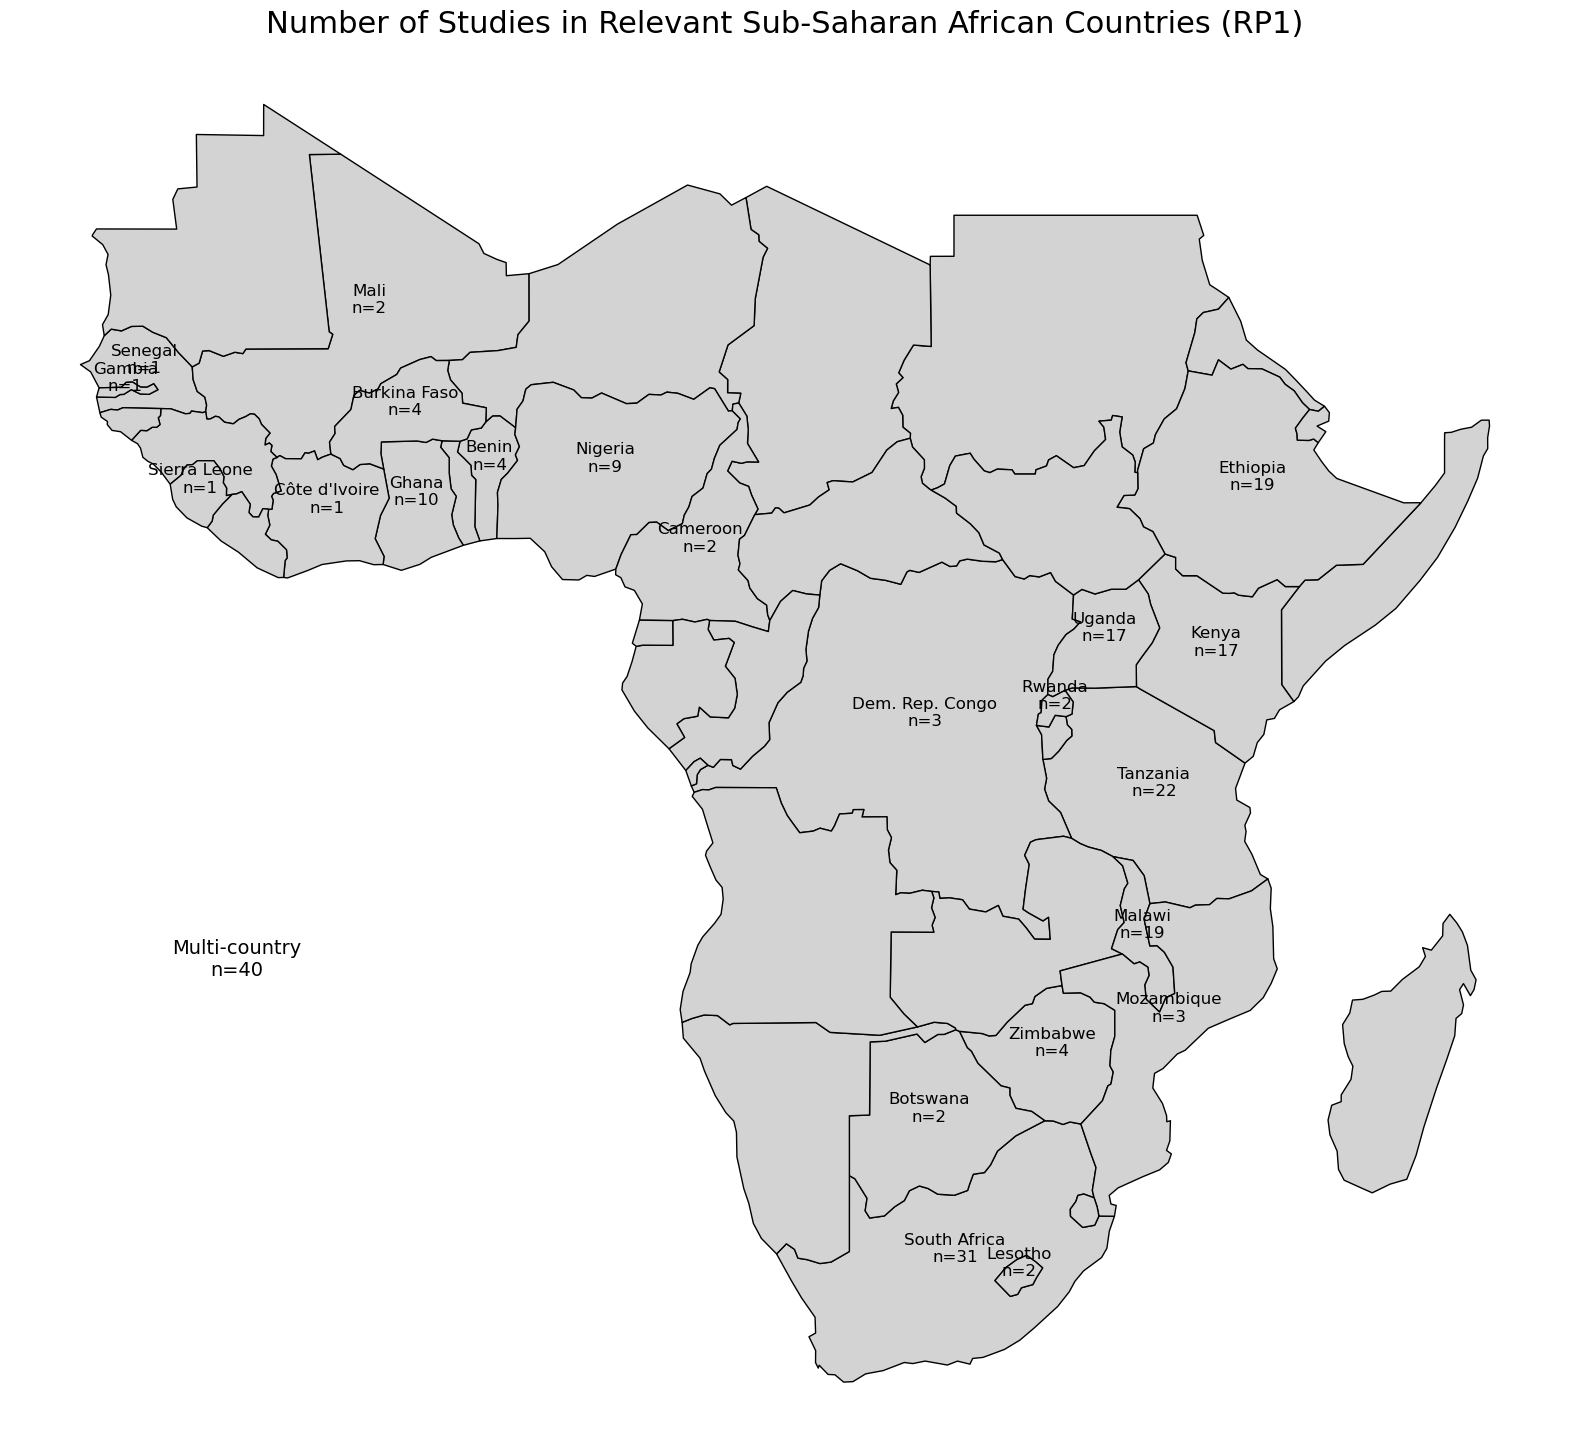

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Load the data from the Excel file
file_path = 'Copy of HEAT_Tables_20.06.24_CPedits.xlsx'
df_rp1_countries = pd.read_excel(file_path, sheet_name='RP1_Countries')

# Print the column names to inspect them
print(df_rp1_countries.columns)

# Set the 'Study site' column as the index
df_rp1_countries.set_index('Study site', inplace=True)

# Ensure the 'TOTAL' column is correctly identified
if 'TOTAL' not in df_rp1_countries.columns:
    print("Error: 'TOTAL' column not found in the data.")
else:
    print("Total studies by country:")
    print(df_rp1_countries['TOTAL'])

# Load a map of Africa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = world[(world['continent'] == 'Africa') & (world['name'] != 'Antarctica')]

# Adjust names for compatibility using ISO 3166-1 alpha-3 codes
name_adjustments = {
    "Benin": "BEN",
    "Botswana": "BWA",
    "Burkina Faso": "BFA",
    "Cameroon": "CMR",
    "Cote d'Ivoire": "CIV",
    "Congo": "COD",
    "DRC": "COG",
    "Eswatini": "SWZ",
    "Ethiopia": "ETH",
    "Gambia": "GMB",
    "Ghana": "GHA",
    "Côte d'Ivoire": "CIV",
    "Kenya": "KEN",
    "Lesotho": "LSO",
    "Malawi": "MWI",
    "Mali": "MLI",
    "Mozambique": "MOZ",
    "Nigeria": "NGA",
    "Rwanda": "RWA",
    "Senegal": "SEN",
    "Sierra Leone": "SLE",
    "South Africa": "ZAF",
    "Tanzania": "TZA",
    "Uganda": "UGA",
    "Zimbabwe": "ZWE",
    "Multi-country": "Multi-country"
}

df_rp1_countries.rename(index=name_adjustments, inplace=True)

# Subset the map to Sub-Saharan Africa
sub_saharan_countries = [
    "AGO", "BEN", "BWA", "BFA", "BDI", "CPV", "CMR", 
    "CAF", "TCD", "COM", "COG", "CIV", "DJI", 
    "GNQ", "ERI", "SWZ", "ETH", "GAB", "GMB", "GHA", 
    "GIN", "GNB", "KEN", "LSO", "LBR", "MDG", "MWI", "MLI", 
    "MRT", "MUS", "MOZ", "NAM", "NER", "NGA", "RWA", "STP", 
    "SEN", "SYC", "SLE", "SOM", "ZAF", "SSD", "SDN", 
    "TZA", "TGO", "UGA", "ZMB", "ZWE", "COD"
]
sub_saharan_africa = africa[africa['iso_a3'].isin(sub_saharan_countries)]

# Plot the map of Sub-Saharan Africa
fig, ax = plt.subplots(figsize=(20, 20))
sub_saharan_africa.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot total studies for each country
for country in df_rp1_countries.index:
    if country in sub_saharan_africa['iso_a3'].values:
        total_studies = int(df_rp1_countries.loc[country, 'TOTAL'])
        country_geom = sub_saharan_africa[sub_saharan_africa['iso_a3'] == country].geometry.centroid
        ax.text(country_geom.x.values[0], country_geom.y.values[0], f"{sub_saharan_africa[sub_saharan_africa['iso_a3'] == country]['name'].values[0]}\nn={total_studies}", fontsize=12, ha='center')

# Plot total studies for Multi-country
multi_country_total = int(df_rp1_countries.loc['Multi-country', 'TOTAL'])
ax.text(-10, -15, f"Multi-country\nn={multi_country_total}", fontsize=14, ha='center')

# Add title
plt.title('Number of Studies in Relevant Sub-Saharan African Countries (RP1)', fontsize=22)

# Remove axes
ax.axis('off')

plt.show()


Total studies by country:
Study site
Benin             4
Botswana          2
Burkina Faso      4
Cameroon          2
Côte d'Ivoire     1
DRC               3
Ethiopia         19
Gambia            1
Ghana            10
Kenya            17
Lesotho           2
Malawi           19
Mali              2
Mozambique        3
Multi-country    40
Nigeria           9
Rwanda            2
Senegal           1
Sierra Leone      1
South Africa     31
Tanzania         22
Uganda           17
Zimbabwe          4
Name: TOTAL, dtype: int64


C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\2062338499.py:20: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\2062338499.py:75: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_geom = sub_saharan_africa[sub_saharan_africa['iso_a3'] == country].geometry.centroid
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\2062338499.py:75: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_geom = sub_sa

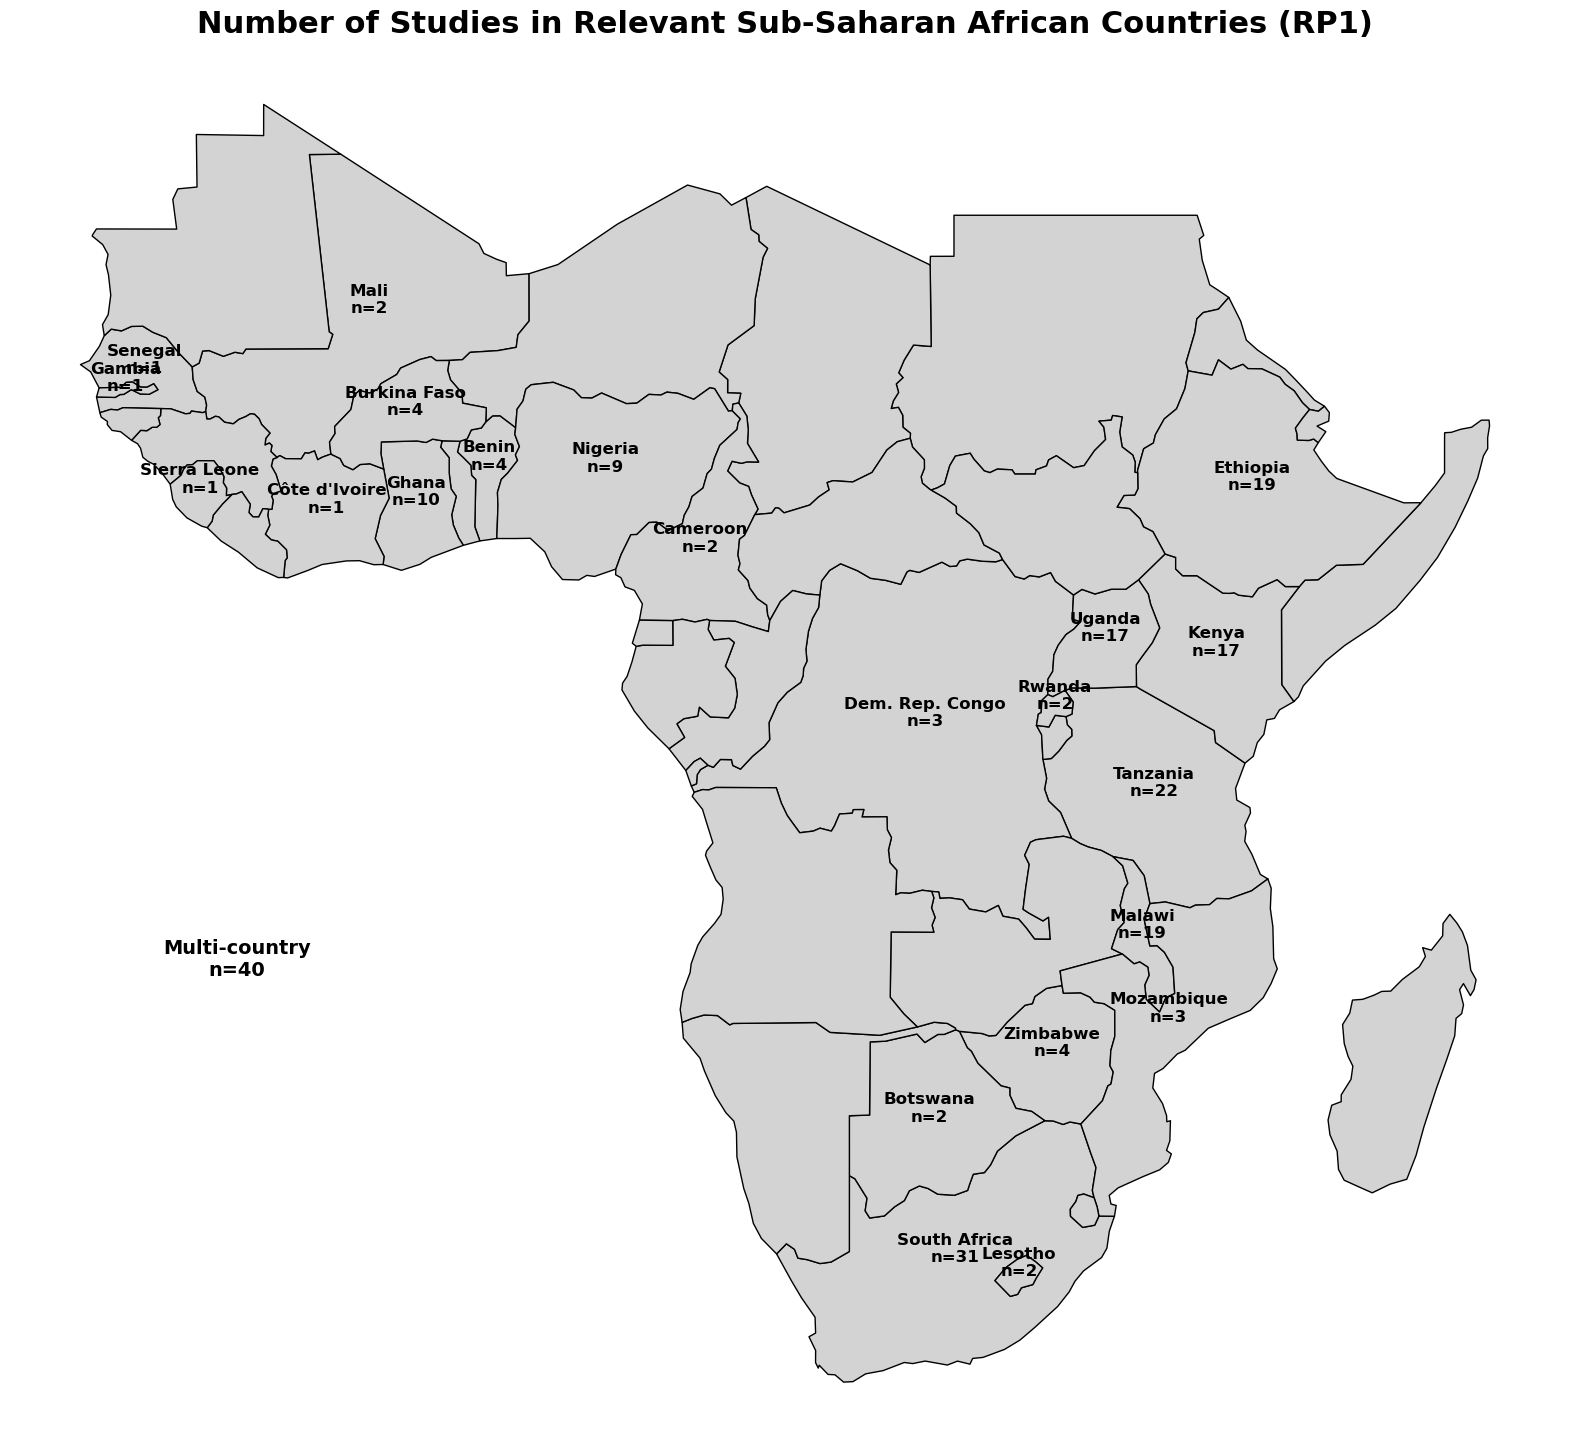

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Load the data from the Excel file
file_path = 'HEAT_Tables_0517_am.xlsx'
df_rp1_countries = pd.read_excel(file_path, sheet_name='RP1_Countries')

# Set the 'Study site' column as the index
df_rp1_countries.set_index('Study site', inplace=True)

# Ensure the 'TOTAL' column is correctly identified
if 'TOTAL' not in df_rp1_countries.columns:
    print("Error: 'TOTAL' column not found in the data.")
else:
    print("Total studies by country:")
    print(df_rp1_countries['TOTAL'])

# Load a map of Africa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = world[(world['continent'] == 'Africa') & (world['name'] != 'Antarctica')]

# Adjust names for compatibility using ISO 3166-1 alpha-3 codes
name_adjustments = {
    "Benin": "BEN",
    "Botswana": "BWA",
    "Burkina Faso": "BFA",
    "Cameroon": "CMR",
    "Côte d'Ivoire": "CIV",
    "DRC": "COD",
    "Congo": "COG",
    "Eswatini": "SWZ",
    "Ethiopia": "ETH",
    "Gambia": "GMB",
    "Ghana": "GHA",
    "Ivory Coast": "CIV",
    "Kenya": "KEN",
    "Lesotho": "LSO",
    "Malawi": "MWI",
    "Mali": "MLI",
    "Mozambique": "MOZ",
    "Nigeria": "NGA",
    "Rwanda": "RWA",
    "Senegal": "SEN",
    "Sierra Leone": "SLE",
    "South Africa": "ZAF",
    "Tanzania": "TZA",
    "Uganda": "UGA",
    "Zimbabwe": "ZWE",
    "Multi-country": "Multi-country"
}

df_rp1_countries.rename(index=name_adjustments, inplace=True)

# Subset the map to Sub-Saharan Africa
sub_saharan_countries = [
    "AGO", "BEN", "BWA", "BFA", "BDI", "CPV", "CMR", 
    "CAF", "TCD", "COM", "COG", "CIV", "DJI", 
    "GNQ", "ERI", "SWZ", "ETH", "GAB", "GMB", "GHA", 
    "GIN", "GNB", "KEN", "LSO", "LBR", "MDG", "MWI", "MLI", 
    "MRT", "MUS", "MOZ", "NAM", "NER", "NGA", "RWA", "STP", 
    "SEN", "SYC", "SLE", "SOM", "ZAF", "SSD", "SDN", 
    "TZA", "TGO", "UGA", "ZMB", "ZWE", "COD"
]
sub_saharan_africa = africa[africa['iso_a3'].isin(sub_saharan_countries)]

# Plot the map of Sub-Saharan Africa
fig, ax = plt.subplots(figsize=(20, 20))
sub_saharan_africa.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot total studies for each country
for country in df_rp1_countries.index:
    if country in sub_saharan_africa['iso_a3'].values:
        total_studies = int(df_rp1_countries.loc[country, 'TOTAL'])
        country_geom = sub_saharan_africa[sub_saharan_africa['iso_a3'] == country].geometry.centroid
        ax.text(country_geom.x.values[0], country_geom.y.values[0], f"{sub_saharan_africa[sub_saharan_africa['iso_a3'] == country]['name'].values[0]}\nn={total_studies}", fontsize=12, ha='center', weight='bold')

# Plot total studies for Multi-country
multi_country_total = int(df_rp1_countries.loc['Multi-country', 'TOTAL'])
ax.text(-10, -15, f"Multi-country\nn={multi_country_total}", fontsize=14, ha='center', weight='bold')

# Add title
plt.title('Number of Studies in Relevant Sub-Saharan African Countries (RP1)', fontsize=22, weight='bold')

# Remove axes
ax.axis('off')

plt.show()


Total studies by country:
Study site
Benin             4
Botswana          2
Burkina Faso      4
Cameroon          2
Côte d'Ivoire     1
DRC               3
Ethiopia         19
Gambia            1
Ghana            10
Kenya            17
Lesotho           2
Malawi           19
Mali              2
Mozambique        3
Multi-country    40
Nigeria           9
Rwanda            2
Senegal           1
Sierra Leone      1
South Africa     31
Tanzania         22
Uganda           17
Zimbabwe          4
Name: TOTAL, dtype: int64


C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\164308698.py:20: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\164308698.py:75: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_geom = sub_saharan_africa[sub_saharan_africa['iso_a3'] == country].geometry.centroid
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\164308698.py:75: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_geom = sub_sahar

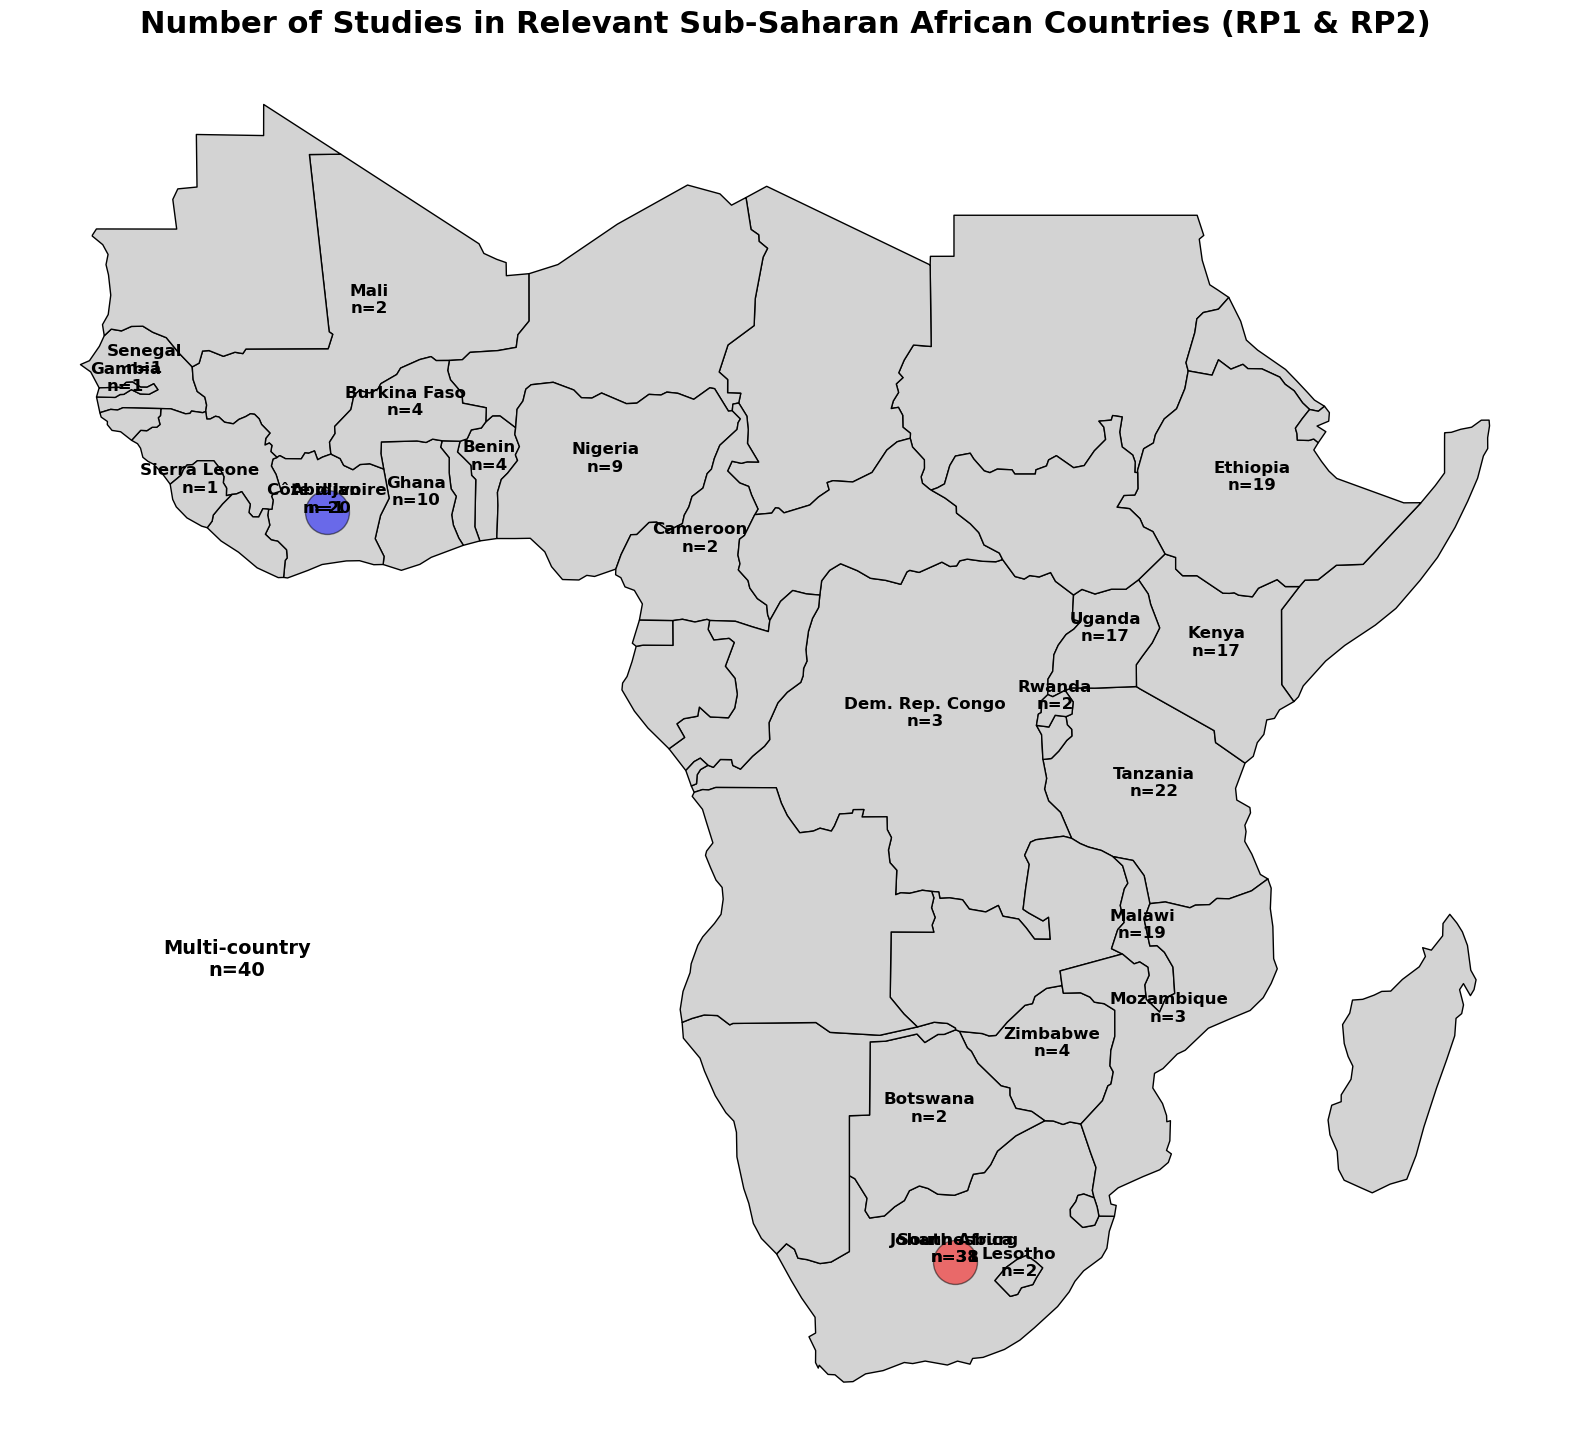

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Load the data from the Excel file
file_path = 'HEAT_Tables_0517_am.xlsx'
df_rp1_countries = pd.read_excel(file_path, sheet_name='RP1_Countries')

# Set the 'Study site' column as the index
df_rp1_countries.set_index('Study site', inplace=True)

# Ensure the 'TOTAL' column is correctly identified
if 'TOTAL' not in df_rp1_countries.columns:
    print("Error: 'TOTAL' column not found in the data.")
else:
    print("Total studies by country:")
    print(df_rp1_countries['TOTAL'])

# Load a map of Africa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = world[(world['continent'] == 'Africa') & (world['name'] != 'Antarctica')]

# Adjust names for compatibility using ISO 3166-1 alpha-3 codes
name_adjustments = {
    "Benin": "BEN",
    "Botswana": "BWA",
    "Burkina Faso": "BFA",
    "Cameroon": "CMR",
    "Côte d'Ivoire": "CIV",
    "DRC": "COD",
    "Congo": "COG",
    "Eswatini": "SWZ",
    "Ethiopia": "ETH",
    "Gambia": "GMB",
    "Ghana": "GHA",
    "Ivory Coast": "CIV",
    "Kenya": "KEN",
    "Lesotho": "LSO",
    "Malawi": "MWI",
    "Mali": "MLI",
    "Mozambique": "MOZ",
    "Nigeria": "NGA",
    "Rwanda": "RWA",
    "Senegal": "SEN",
    "Sierra Leone": "SLE",
    "South Africa": "ZAF",
    "Tanzania": "TZA",
    "Uganda": "UGA",
    "Zimbabwe": "ZWE",
    "Multi-country": "Multi-country"
}

df_rp1_countries.rename(index=name_adjustments, inplace=True)

# Subset the map to Sub-Saharan Africa
sub_saharan_countries = [
    "AGO", "BEN", "BWA", "BFA", "BDI", "CPV", "CMR", 
    "CAF", "TCD", "COM", "COG", "CIV", "DJI", 
    "GNQ", "ERI", "SWZ", "ETH", "GAB", "GMB", "GHA", 
    "GIN", "GNB", "KEN", "LSO", "LBR", "MDG", "MWI", "MLI", 
    "MRT", "MUS", "MOZ", "NAM", "NER", "NGA", "RWA", "STP", 
    "SEN", "SYC", "SLE", "SOM", "ZAF", "SSD", "SDN", 
    "TZA", "TGO", "UGA", "ZMB", "ZWE", "COD"
]
sub_saharan_africa = africa[africa['iso_a3'].isin(sub_saharan_countries)]

# Plot the map of Sub-Saharan Africa
fig, ax = plt.subplots(figsize=(20, 20))
sub_saharan_africa.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot total studies for each country
for country in df_rp1_countries.index:
    if country in sub_saharan_africa['iso_a3'].values:
        total_studies = int(df_rp1_countries.loc[country, 'TOTAL'])
        country_geom = sub_saharan_africa[sub_saharan_africa['iso_a3'] == country].geometry.centroid
        ax.text(country_geom.x.values[0], country_geom.y.values[0], f"{sub_saharan_africa[sub_saharan_africa['iso_a3'] == country]['name'].values[0]}\nn={total_studies}", fontsize=12, ha='center', weight='bold')

# Plot total studies for Multi-country
multi_country_total = int(df_rp1_countries.loc['Multi-country', 'TOTAL'])
ax.text(-10, -15, f"Multi-country\nn={multi_country_total}", fontsize=14, ha='center', weight='bold')

# Add bubbles for Johannesburg and Abidjan
johannesburg = sub_saharan_africa[sub_saharan_africa['iso_a3'] == "ZAF"].geometry.centroid
ax.scatter(johannesburg.x.values[0], johannesburg.y.values[0], s=1000, color='red', alpha=0.5, edgecolor='black')
ax.text(johannesburg.x.values[0], johannesburg.y.values[0], "Johannesburg\nn=38", fontsize=12, ha='center', weight='bold')

abidjan = sub_saharan_africa[sub_saharan_africa['iso_a3'] == "CIV"].geometry.centroid
ax.scatter(abidjan.x.values[0], abidjan.y.values[0], s=1000, color='blue', alpha=0.5, edgecolor='black')
ax.text(abidjan.x.values[0], abidjan.y.values[0], "Abidjan\nn=20", fontsize=12, ha='center', weight='bold')

# Add title
plt.title('Number of Studies in Relevant Sub-Saharan African Countries (RP1 & RP2)', fontsize=22, weight='bold')

# Remove axes
ax.axis('off')

plt.show()


Total studies by country:
Study site
Benin             4
Botswana          2
Burkina Faso      4
Cameroon          2
Côte d'Ivoire     1
DRC               3
Ethiopia         19
Gambia            1
Ghana            10
Kenya            17
Lesotho           2
Malawi           19
Mali              2
Mozambique        3
Multi-country    40
Nigeria           9
Rwanda            2
Senegal           1
Sierra Leone      1
South Africa     31
Tanzania         22
Uganda           17
Zimbabwe          4
Name: TOTAL, dtype: int64


C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\3188602604.py:20: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\3188602604.py:75: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_geom = sub_saharan_africa[sub_saharan_africa['iso_a3'] == country].geometry.centroid
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\3188602604.py:75: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_geom = sub_sa

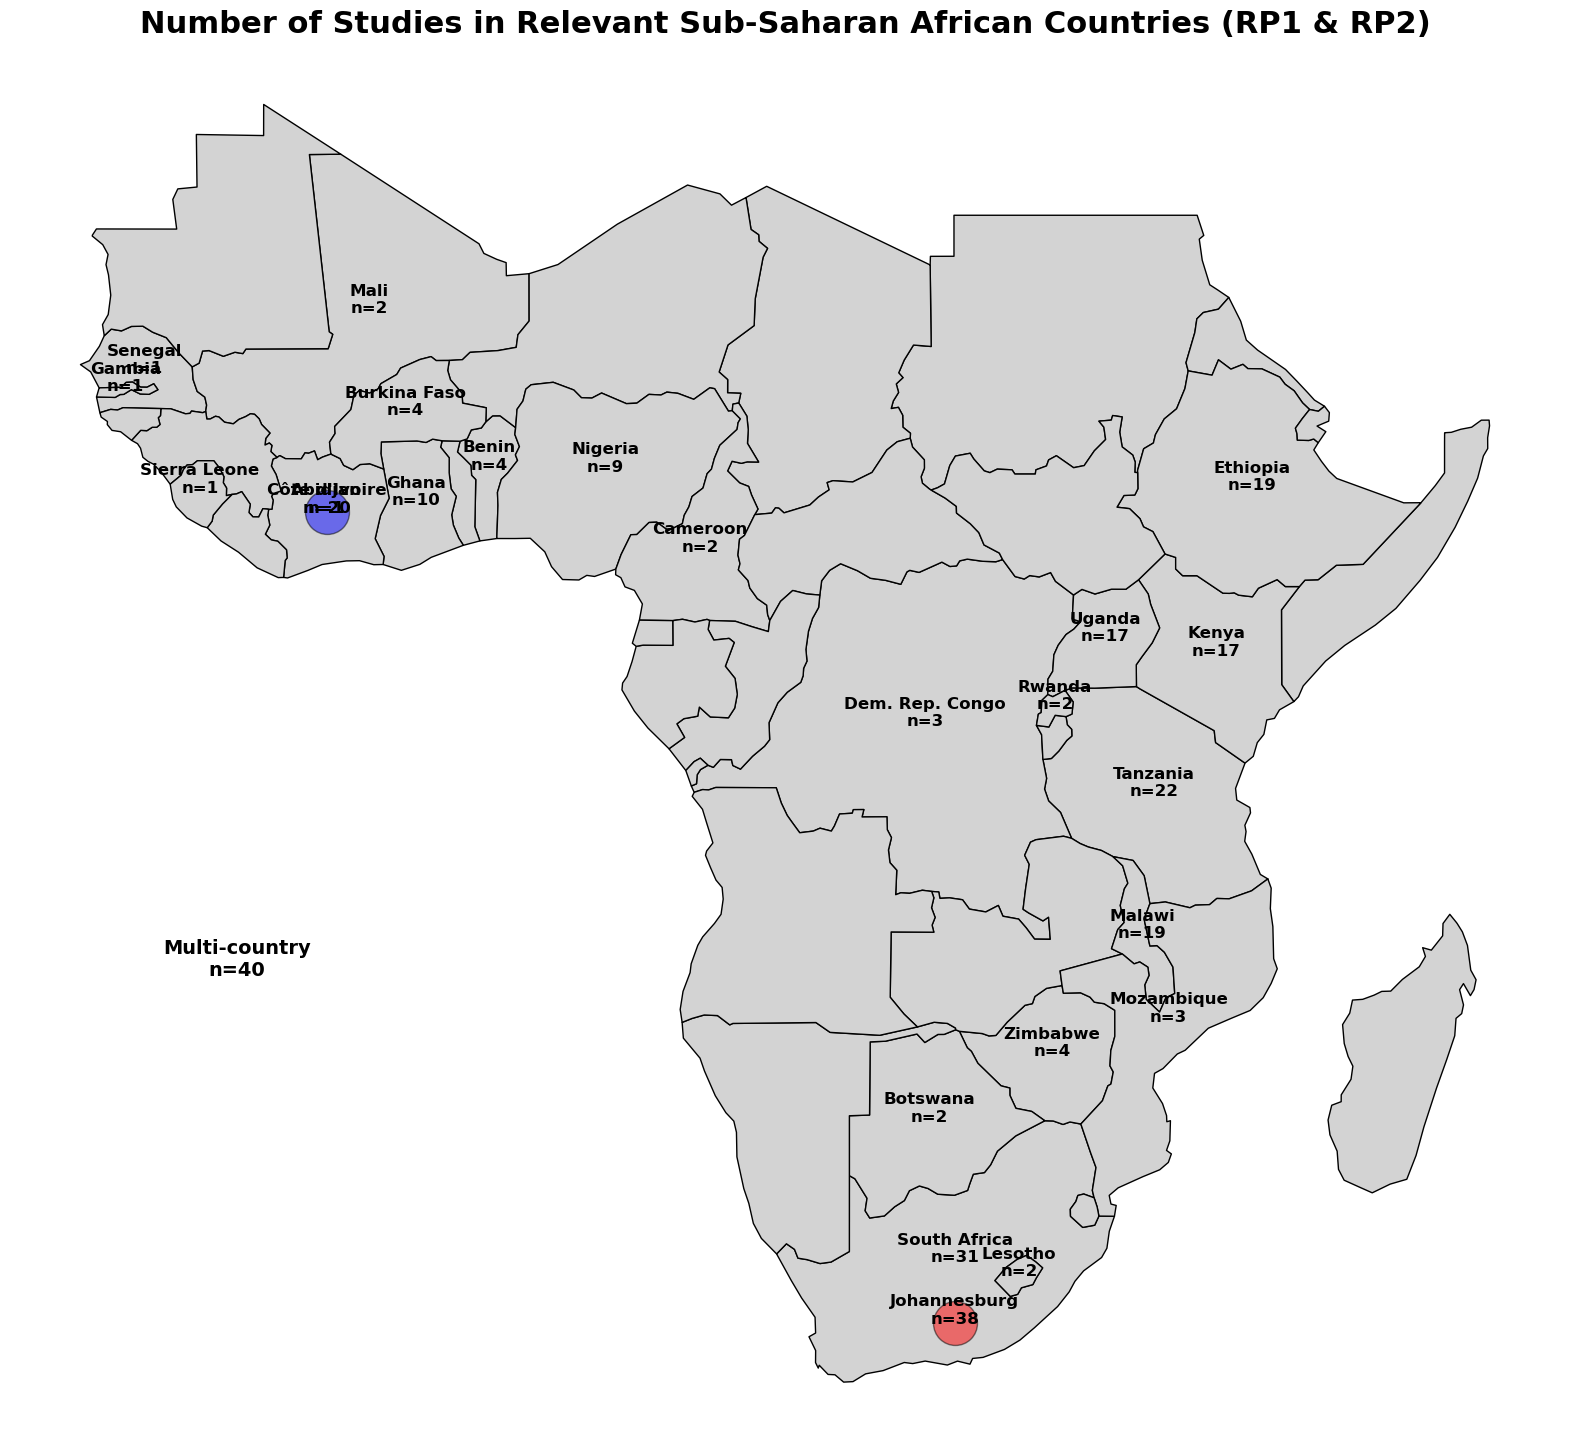

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Load the data from the Excel file
file_path = 'HEAT_Tables_0517_am.xlsx'
df_rp1_countries = pd.read_excel(file_path, sheet_name='RP1_Countries')

# Set the 'Study site' column as the index
df_rp1_countries.set_index('Study site', inplace=True)

# Ensure the 'TOTAL' column is correctly identified
if 'TOTAL' not in df_rp1_countries.columns:
    print("Error: 'TOTAL' column not found in the data.")
else:
    print("Total studies by country:")
    print(df_rp1_countries['TOTAL'])

# Load a map of Africa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = world[(world['continent'] == 'Africa') & (world['name'] != 'Antarctica')]

# Adjust names for compatibility using ISO 3166-1 alpha-3 codes
name_adjustments = {
    "Benin": "BEN",
    "Botswana": "BWA",
    "Burkina Faso": "BFA",
    "Cameroon": "CMR",
    "Côte d'Ivoire": "CIV",
    "DRC": "COD",
    "Congo": "COG",
    "Eswatini": "SWZ",
    "Ethiopia": "ETH",
    "Gambia": "GMB",
    "Ghana": "GHA",
    "Ivory Coast": "CIV",
    "Kenya": "KEN",
    "Lesotho": "LSO",
    "Malawi": "MWI",
    "Mali": "MLI",
    "Mozambique": "MOZ",
    "Nigeria": "NGA",
    "Rwanda": "RWA",
    "Senegal": "SEN",
    "Sierra Leone": "SLE",
    "South Africa": "ZAF",
    "Tanzania": "TZA",
    "Uganda": "UGA",
    "Zimbabwe": "ZWE",
    "Multi-country": "Multi-country"
}

df_rp1_countries.rename(index=name_adjustments, inplace=True)

# Subset the map to Sub-Saharan Africa
sub_saharan_countries = [
    "AGO", "BEN", "BWA", "BFA", "BDI", "CPV", "CMR", 
    "CAF", "TCD", "COM", "COG", "CIV", "DJI", 
    "GNQ", "ERI", "SWZ", "ETH", "GAB", "GMB", "GHA", 
    "GIN", "GNB", "KEN", "LSO", "LBR", "MDG", "MWI", "MLI", 
    "MRT", "MUS", "MOZ", "NAM", "NER", "NGA", "RWA", "STP", 
    "SEN", "SYC", "SLE", "SOM", "ZAF", "SSD", "SDN", 
    "TZA", "TGO", "UGA", "ZMB", "ZWE", "COD"
]
sub_saharan_africa = africa[africa['iso_a3'].isin(sub_saharan_countries)]

# Plot the map of Sub-Saharan Africa
fig, ax = plt.subplots(figsize=(20, 20))
sub_saharan_africa.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot total studies for each country
for country in df_rp1_countries.index:
    if country in sub_saharan_africa['iso_a3'].values:
        total_studies = int(df_rp1_countries.loc[country, 'TOTAL'])
        country_geom = sub_saharan_africa[sub_saharan_africa['iso_a3'] == country].geometry.centroid
        ax.text(country_geom.x.values[0], country_geom.y.values[0], f"{sub_saharan_africa[sub_saharan_africa['iso_a3'] == country]['name'].values[0]}\nn={total_studies}", fontsize=12, ha='center', weight='bold')

# Plot total studies for Multi-country
multi_country_total = int(df_rp1_countries.loc['Multi-country', 'TOTAL'])
ax.text(-10, -15, f"Multi-country\nn={multi_country_total}", fontsize=14, ha='center', weight='bold')

# Add bubbles for Johannesburg and Abidjan with offset
johannesburg = sub_saharan_africa[sub_saharan_africa['iso_a3'] == "ZAF"].geometry.centroid
ax.scatter(johannesburg.x.values[0], johannesburg.y.values[0] - 3, s=1000, color='red', alpha=0.5, edgecolor='black')
ax.text(johannesburg.x.values[0], johannesburg.y.values[0] - 3, "Johannesburg\nn=38", fontsize=12, ha='center', weight='bold')

abidjan = sub_saharan_africa[sub_saharan_africa['iso_a3'] == "CIV"].geometry.centroid
ax.scatter(abidjan.x.values[0] -0, abidjan.y.values[0], s=1000, color='blue', alpha=0.5, edgecolor='black')
ax.text(abidjan.x.values[0] -0, abidjan.y.values[0], "Abidjan\nn=20", fontsize=12, ha='center', weight='bold')

# Add title
plt.title('Number of Studies in Relevant Sub-Saharan African Countries (RP1 & RP2)', fontsize=22, weight='bold')

# Remove axes
ax.axis('off')

plt.show()


Total studies by country:
Study site
Benin             4
Botswana          2
Burkina Faso      4
Cameroon          2
Côte d'Ivoire     1
DRC               3
Ethiopia         19
Gambia            1
Ghana            10
Kenya            17
Lesotho           2
Malawi           19
Mali              2
Mozambique        3
Multi-country    40
Nigeria           9
Rwanda            2
Senegal           1
Sierra Leone      1
South Africa     31
Tanzania         22
Uganda           17
Zimbabwe          4
Name: TOTAL, dtype: int64


C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\3880938213.py:20: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\3880938213.py:76: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_geom = sub_saharan_africa[sub_saharan_africa['iso_a3'] == country].geometry.centroid
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\3880938213.py:76: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_geom = sub_sa

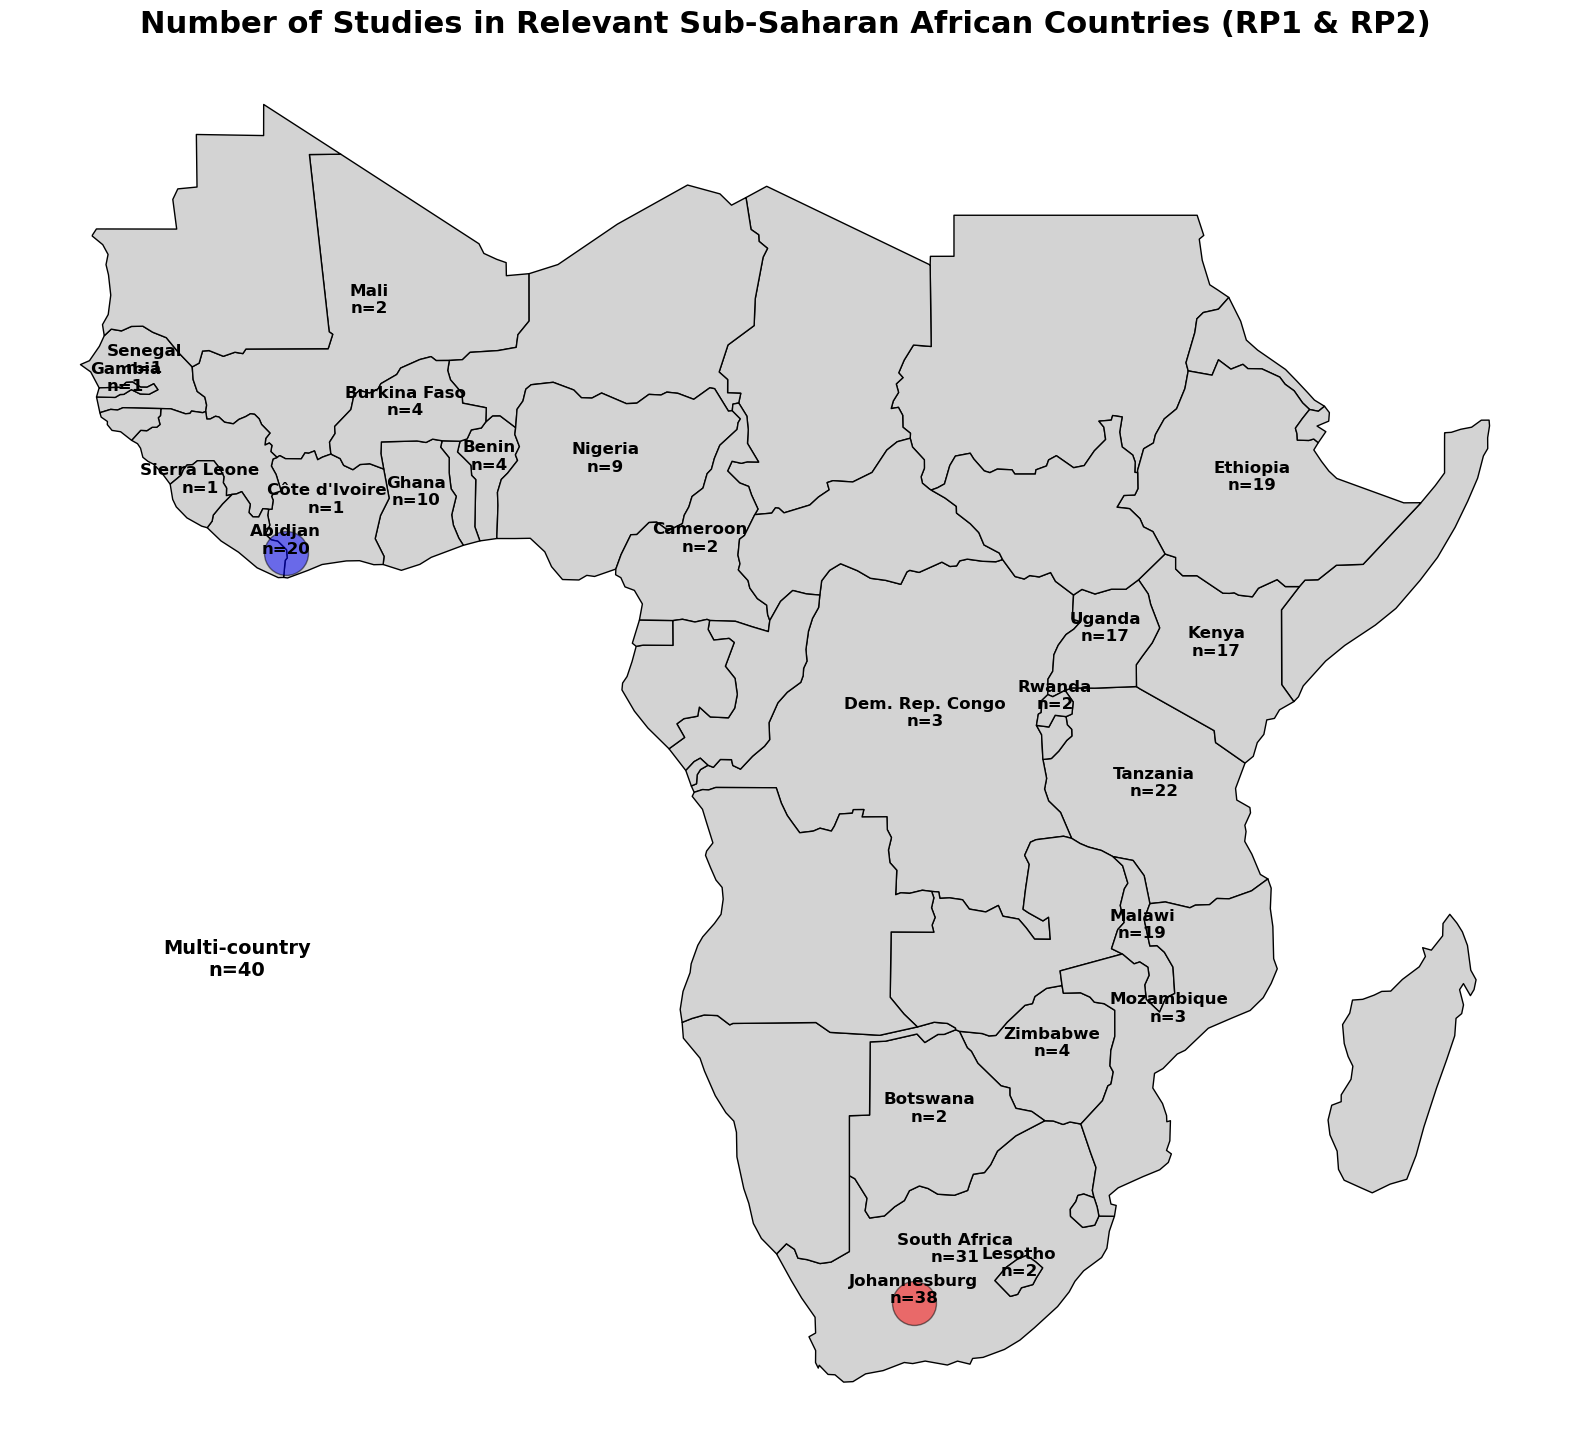

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Load the data from the Excel file
file_path = 'HEAT_Tables_0517_am.xlsx'
df_rp1_countries = pd.read_excel(file_path, sheet_name='RP1_Countries')

# Set the 'Study site' column as the index
df_rp1_countries.set_index('Study site', inplace=True)

# Ensure the 'TOTAL' column is correctly identified
if 'TOTAL' not in df_rp1_countries.columns:
    print("Error: 'TOTAL' column not found in the data.")
else:
    print("Total studies by country:")
    print(df_rp1_countries['TOTAL'])

# Load a map of Africa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = world[(world['continent'] == 'Africa') & (world['name'] != 'Antarctica')]

# Adjust names for compatibility using ISO 3166-1 alpha-3 codes
name_adjustments = {
    "Benin": "BEN",
    "Botswana": "BWA",
    "Burkina Faso": "BFA",
    "Cameroon": "CMR",
    "Côte d'Ivoire": "CIV",
    "DRC": "COD",
    "Congo": "COG",
    "Eswatini": "SWZ",
    "Ethiopia": "ETH",
    "Gambia": "GMB",
    "Ghana": "GHA",
    "Ivory Coast": "CIV",
    "Kenya": "KEN",
    "Lesotho": "LSO",
    "Malawi": "MWI",
    "Mali": "MLI",
    "Mozambique": "MOZ",
    "Nigeria": "NGA",
    "Rwanda": "RWA",
    "Senegal": "SEN",
    "Sierra Leone": "SLE",
    "South Africa": "ZAF",
    "Tanzania": "TZA",
    "Uganda": "UGA",
    "Zimbabwe": "ZWE",
    "Multi-country": "Multi-country"
}

df_rp1_countries.rename(index=name_adjustments, inplace=True)

# Subset the map to Sub-Saharan Africa
sub_saharan_countries = [
    "AGO", "BEN", "BWA", "BFA", "BDI", "CPV", "CMR", 
    "CAF", "TCD", "COM", "COG", "CIV", "DJI", 
    "GNQ", "ERI", "SWZ", "ETH", "GAB", "GMB", "GHA", 
    "GIN", "GNB", "KEN", "LSO", "LBR", "MDG", "MWI", "MLI", 
    "MRT", "MUS", "MOZ", "NAM", "NER", "NGA", "RWA", "STP", 
    "SEN", "SYC", "SLE", "SOM", "ZAF", "SSD", "SDN", 
    "TZA", "TGO", "UGA", "ZMB", "ZWE", "COD"
]
sub_saharan_africa = africa[africa['iso_a3'].isin(sub_saharan_countries)]

def plot_map(johannesburg_offset=(0, 0), abidjan_offset=(0, 0)):
    # Plot the map of Sub-Saharan Africa
    fig, ax = plt.subplots(figsize=(20, 20))
    sub_saharan_africa.plot(ax=ax, color='lightgrey', edgecolor='black')

    # Plot total studies for each country
    for country in df_rp1_countries.index:
        if country in sub_saharan_africa['iso_a3'].values:
            total_studies = int(df_rp1_countries.loc[country, 'TOTAL'])
            country_geom = sub_saharan_africa[sub_saharan_africa['iso_a3'] == country].geometry.centroid
            ax.text(country_geom.x.values[0], country_geom.y.values[0], f"{sub_saharan_africa[sub_saharan_africa['iso_a3'] == country]['name'].values[0]}\nn={total_studies}", fontsize=12, ha='center', weight='bold')

    # Plot total studies for Multi-country
    multi_country_total = int(df_rp1_countries.loc['Multi-country', 'TOTAL'])
    ax.text(-10, -15, f"Multi-country\nn={multi_country_total}", fontsize=14, ha='center', weight='bold')

    # Add bubbles for Johannesburg and Abidjan with offsets
    johannesburg = sub_saharan_africa[sub_saharan_africa['iso_a3'] == "ZAF"].geometry.centroid
    ax.scatter(johannesburg.x.values[0] + johannesburg_offset[0], johannesburg.y.values[0] + johannesburg_offset[1], s=1000, color='red', alpha=0.5, edgecolor='black')
    ax.text(johannesburg.x.values[0] + johannesburg_offset[0], johannesburg.y.values[0] + johannesburg_offset[1], "Johannesburg\nn=38", fontsize=12, ha='center', weight='bold')

    abidjan = sub_saharan_africa[sub_saharan_africa['iso_a3'] == "CIV"].geometry.centroid
    ax.scatter(abidjan.x.values[0] + abidjan_offset[0], abidjan.y.values[0] + abidjan_offset[0], s=1000, color='blue', alpha=0.5, edgecolor='black')
    ax.text(abidjan.x.values[0] + abidjan_offset[0], abidjan.y.values[0] + abidjan_offset[0], "Abidjan\nn=20", fontsize=12, ha='center', weight='bold')

    # Add title
    plt.title('Number of Studies in Relevant Sub-Saharan African Countries (RP1 & RP2)', fontsize=22, weight='bold')

    # Remove axes
    ax.axis('off')

    plt.show()

# Example usage
plot_map(johannesburg_offset=(-2, -2), abidjan_offset=(-2, -3))


Total studies by country:
Study site
Benin             4
Botswana          2
Burkina Faso      4
Cameroon          2
Côte d'Ivoire     1
DRC               3
Ethiopia         19
Gambia            1
Ghana            10
Kenya            17
Lesotho           2
Malawi           19
Mali              2
Mozambique        3
Multi-country    40
Nigeria           9
Rwanda            2
Senegal           1
Sierra Leone      1
South Africa     31
Tanzania         22
Uganda           17
Zimbabwe          4
Name: TOTAL, dtype: int64


C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\2587986213.py:20: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\2587986213.py:76: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_geom = sub_saharan_africa[sub_saharan_africa['iso_a3'] == country].geometry.centroid
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\2587986213.py:76: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_geom = sub_sa

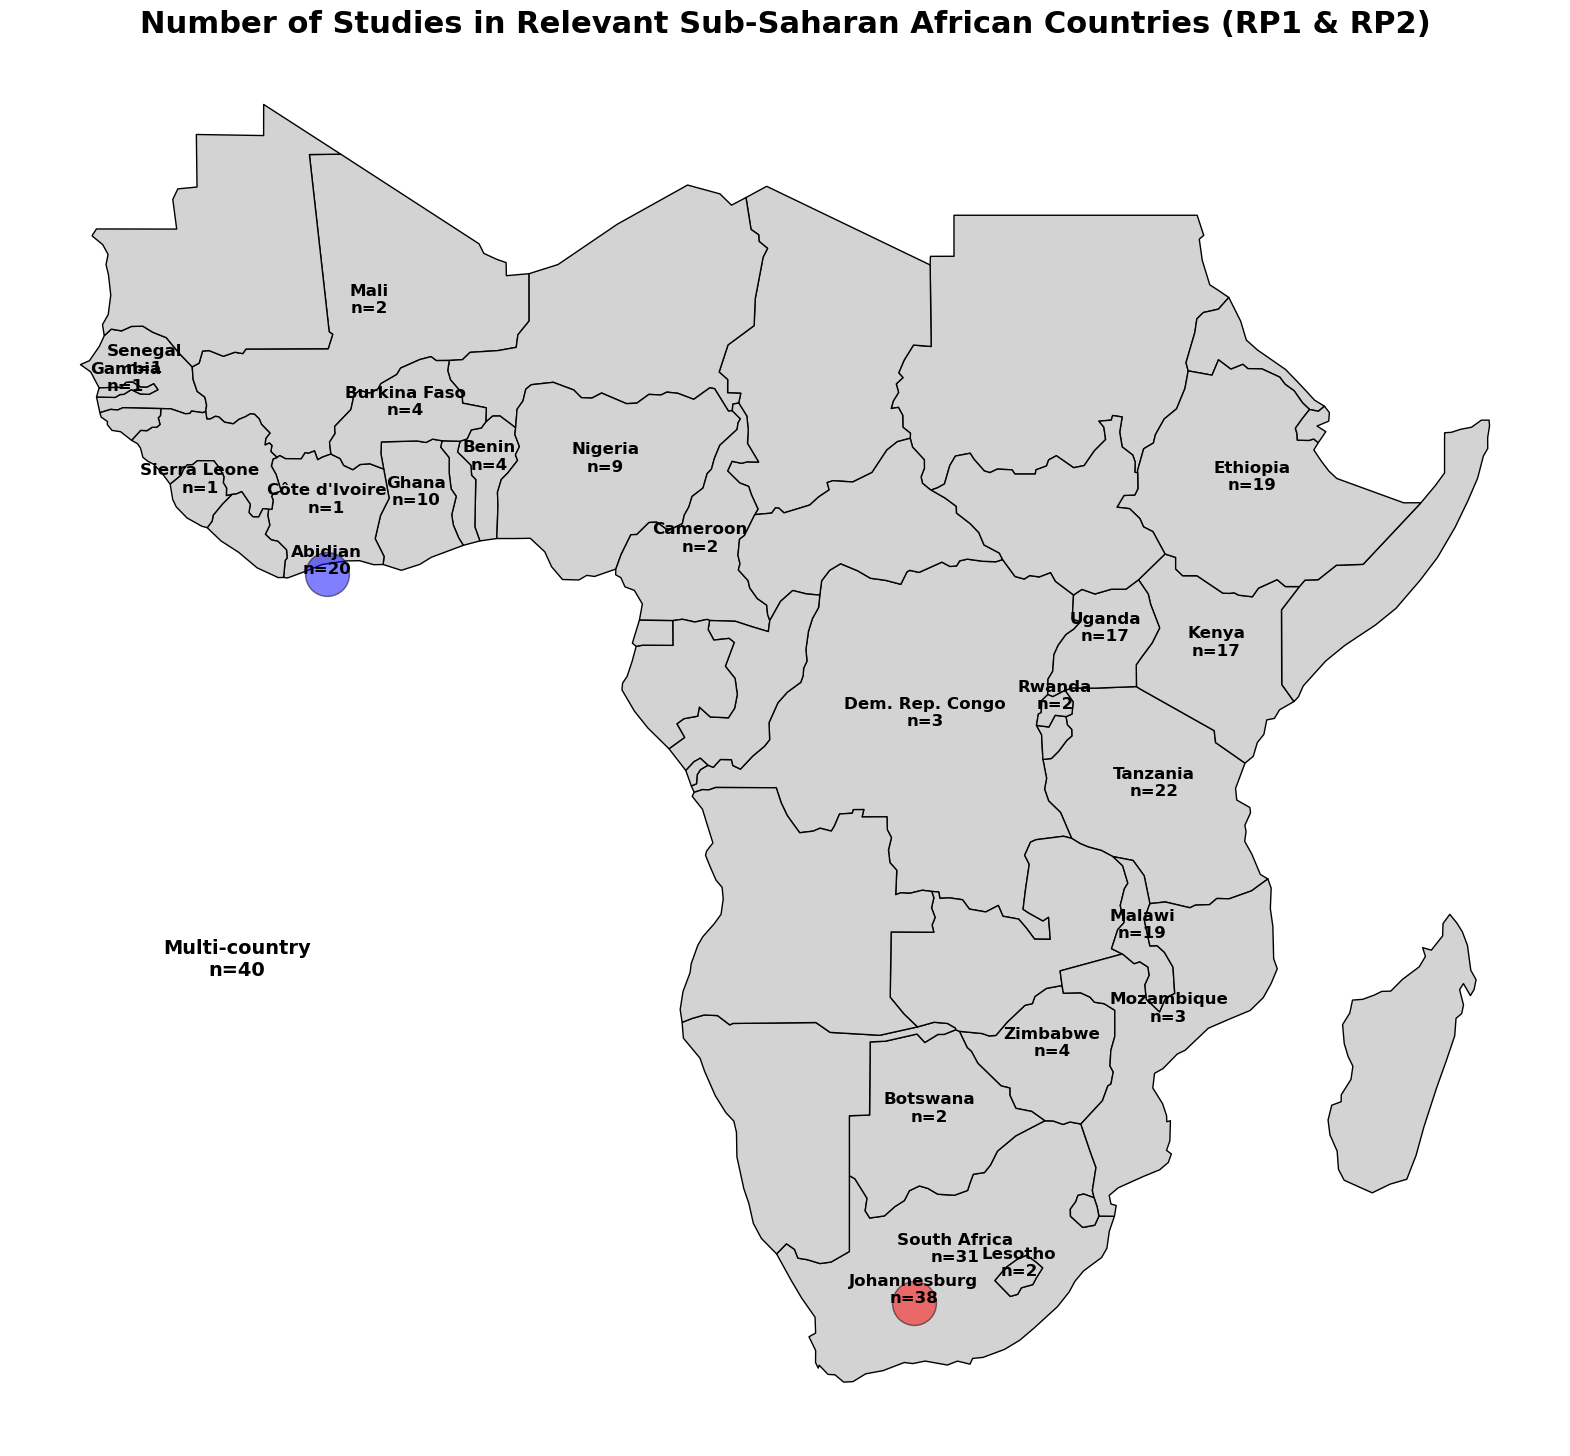

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Load the data from the Excel file
file_path = 'HEAT_Tables_0517_am.xlsx'
df_rp1_countries = pd.read_excel(file_path, sheet_name='RP1_Countries')

# Set the 'Study site' column as the index
df_rp1_countries.set_index('Study site', inplace=True)

# Ensure the 'TOTAL' column is correctly identified
if 'TOTAL' not in df_rp1_countries.columns:
    print("Error: 'TOTAL' column not found in the data.")
else:
    print("Total studies by country:")
    print(df_rp1_countries['TOTAL'])

# Load a map of Africa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = world[(world['continent'] == 'Africa') & (world['name'] != 'Antarctica')]

# Adjust names for compatibility using ISO 3166-1 alpha-3 codes
name_adjustments = {
    "Benin": "BEN",
    "Botswana": "BWA",
    "Burkina Faso": "BFA",
    "Cameroon": "CMR",
    "Côte d'Ivoire": "CIV",
    "DRC": "COD",
    "Congo": "COG",
    "Eswatini": "SWZ",
    "Ethiopia": "ETH",
    "Gambia": "GMB",
    "Ghana": "GHA",
    "Ivory Coast": "CIV",
    "Kenya": "KEN",
    "Lesotho": "LSO",
    "Malawi": "MWI",
    "Mali": "MLI",
    "Mozambique": "MOZ",
    "Nigeria": "NGA",
    "Rwanda": "RWA",
    "Senegal": "SEN",
    "Sierra Leone": "SLE",
    "South Africa": "ZAF",
    "Tanzania": "TZA",
    "Uganda": "UGA",
    "Zimbabwe": "ZWE",
    "Multi-country": "Multi-country"
}

df_rp1_countries.rename(index=name_adjustments, inplace=True)

# Subset the map to Sub-Saharan Africa
sub_saharan_countries = [
    "AGO", "BEN", "BWA", "BFA", "BDI", "CPV", "CMR", 
    "CAF", "TCD", "COM", "COG", "CIV", "DJI", 
    "GNQ", "ERI", "SWZ", "ETH", "GAB", "GMB", "GHA", 
    "GIN", "GNB", "KEN", "LSO", "LBR", "MDG", "MWI", "MLI", 
    "MRT", "MUS", "MOZ", "NAM", "NER", "NGA", "RWA", "STP", 
    "SEN", "SYC", "SLE", "SOM", "ZAF", "SSD", "SDN", 
    "TZA", "TGO", "UGA", "ZMB", "ZWE", "COD"
]
sub_saharan_africa = africa[africa['iso_a3'].isin(sub_saharan_countries)]

def plot_map(johannesburg_offset=(0, 0), abidjan_offset=(0, 0)):
    # Plot the map of Sub-Saharan Africa
    fig, ax = plt.subplots(figsize=(20, 20))
    sub_saharan_africa.plot(ax=ax, color='lightgrey', edgecolor='black')

    # Plot total studies for each country
    for country in df_rp1_countries.index:
        if country in sub_saharan_africa['iso_a3'].values:
            total_studies = int(df_rp1_countries.loc[country, 'TOTAL'])
            country_geom = sub_saharan_africa[sub_saharan_africa['iso_a3'] == country].geometry.centroid
            ax.text(country_geom.x.values[0], country_geom.y.values[0], f"{sub_saharan_africa[sub_saharan_africa['iso_a3'] == country]['name'].values[0]}\nn={total_studies}", fontsize=12, ha='center', weight='bold')

    # Plot total studies for Multi-country
    multi_country_total = int(df_rp1_countries.loc['Multi-country', 'TOTAL'])
    ax.text(-10, -15, f"Multi-country\nn={multi_country_total}", fontsize=14, ha='center', weight='bold')

    # Add bubbles for Johannesburg and Abidjan with offsets
    johannesburg = sub_saharan_africa[sub_saharan_africa['iso_a3'] == "ZAF"].geometry.centroid
    ax.scatter(johannesburg.x.values[0] + johannesburg_offset[0], johannesburg.y.values[0] + johannesburg_offset[1], s=1000, color='red', alpha=0.5, edgecolor='black')
    ax.text(johannesburg.x.values[0] + johannesburg_offset[0], johannesburg.y.values[0] + johannesburg_offset[1], "Johannesburg\nn=38", fontsize=12, ha='center', weight='bold')

    abidjan = sub_saharan_africa[sub_saharan_africa['iso_a3'] == "CIV"].geometry.centroid
    ax.scatter(abidjan.x.values[0] + abidjan_offset[0], abidjan.y.values[0] + abidjan_offset[1], s=1000, color='blue', alpha=0.5, edgecolor='black')
    ax.text(abidjan.x.values[0] + abidjan_offset[0], abidjan.y.values[0] + abidjan_offset[1], "Abidjan\nn=20", fontsize=12, ha='center', weight='bold')

    # Add title
    plt.title('Number of Studies in Relevant Sub-Saharan African Countries (RP1 & RP2)', fontsize=22, weight='bold')

    # Remove axes
    ax.axis('off')

    plt.show()

# Example usage with adjusted offsets for better label clarity
plot_map(johannesburg_offset=(-2, -2), abidjan_offset=(0, -3))


Total studies by country:
Study site
Benin             4
Botswana          2
Burkina Faso      4
Cameroon          2
Côte d'Ivoire     1
DRC               3
Ethiopia         19
Gambia            1
Ghana            10
Kenya            17
Lesotho           2
Malawi           19
Mali              2
Mozambique        3
Multi-country    40
Nigeria           9
Rwanda            2
Senegal           1
Sierra Leone      1
South Africa     31
Tanzania         22
Uganda           17
Zimbabwe          4
Name: TOTAL, dtype: int64


C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\407584928.py:20: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\407584928.py:76: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_geom = sub_saharan_africa[sub_saharan_africa['iso_a3'] == country].geometry.centroid
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\407584928.py:76: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_geom = sub_sahar

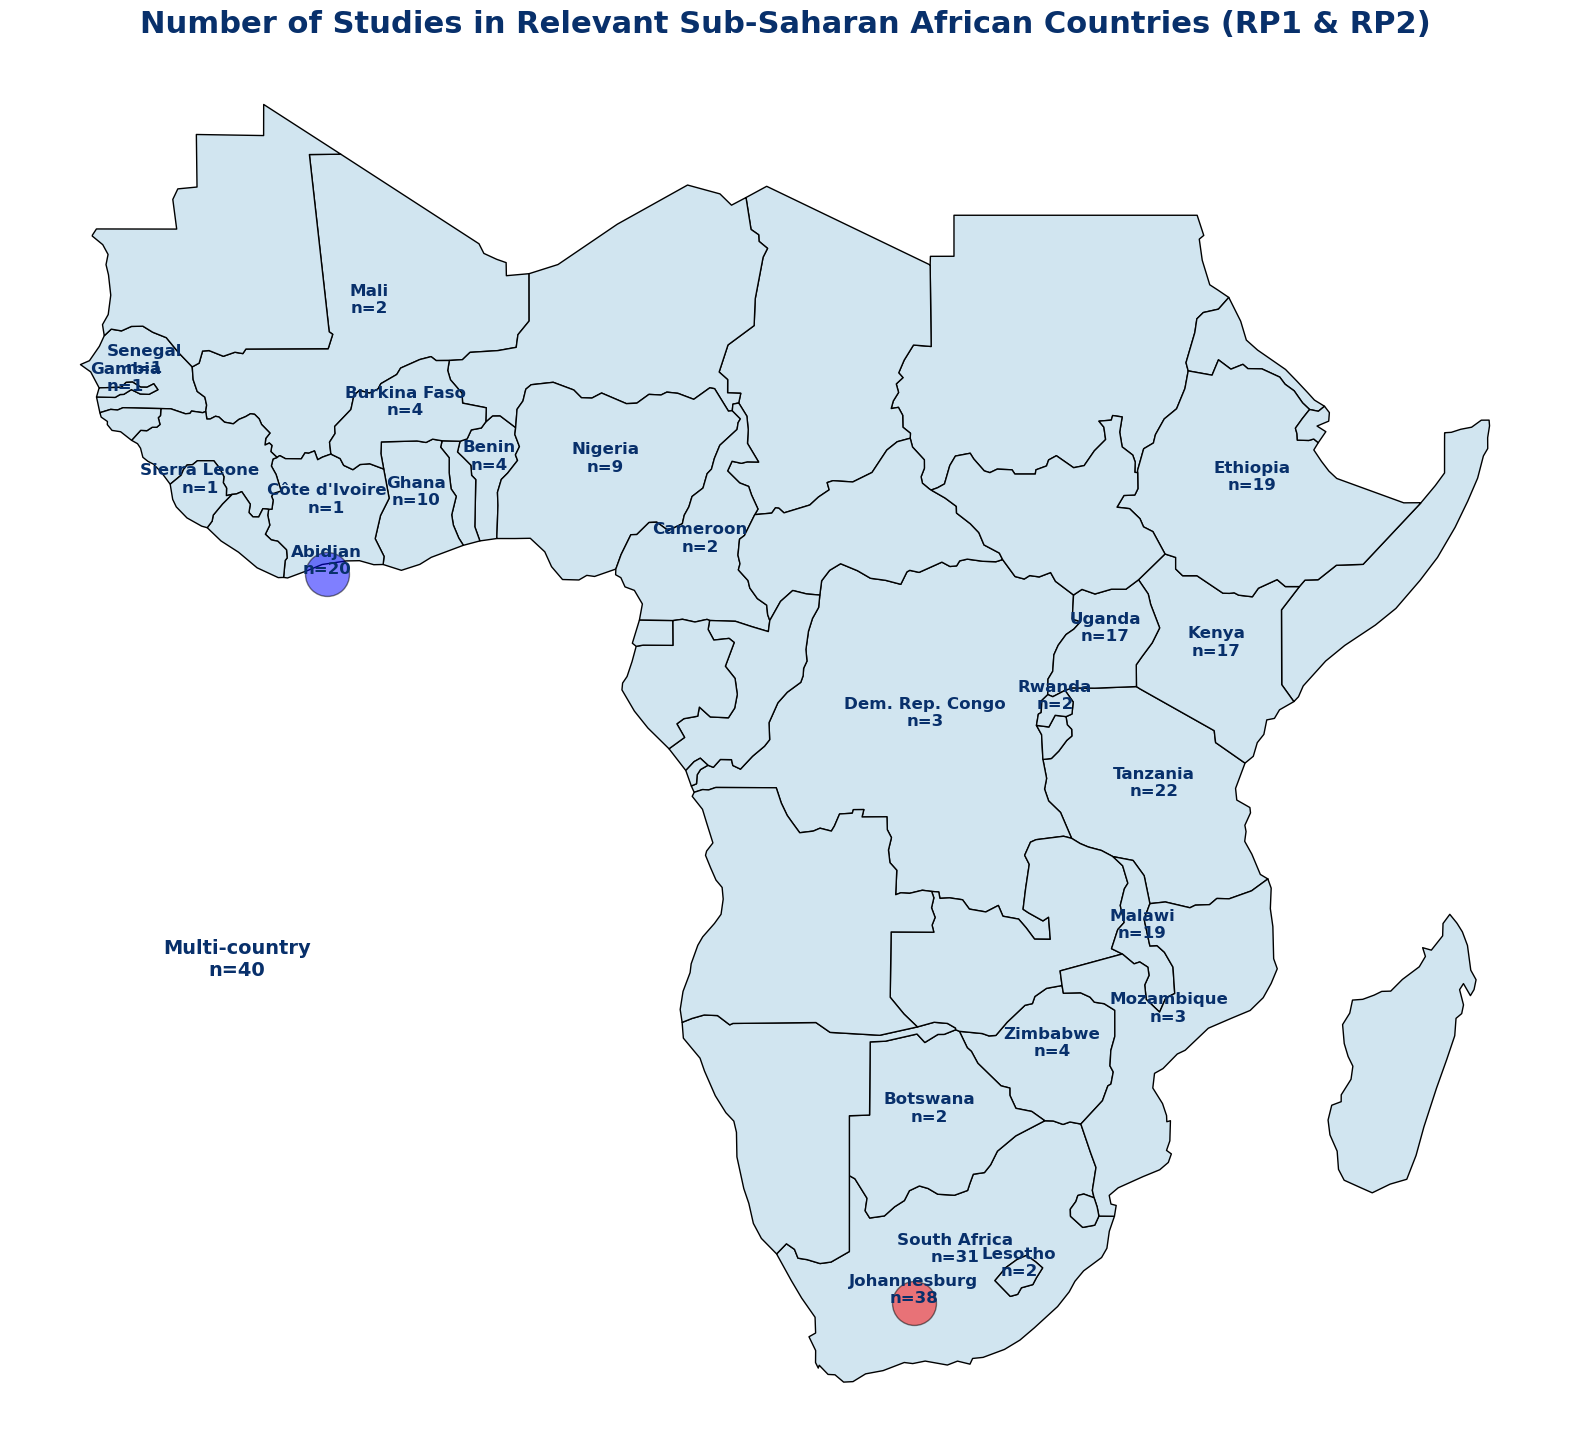

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Load the data from the Excel file
file_path = 'HEAT_Tables_0517_am.xlsx'
df_rp1_countries = pd.read_excel(file_path, sheet_name='RP1_Countries')

# Set the 'Study site' column as the index
df_rp1_countries.set_index('Study site', inplace=True)

# Ensure the 'TOTAL' column is correctly identified
if 'TOTAL' not in df_rp1_countries.columns:
    print("Error: 'TOTAL' column not found in the data.")
else:
    print("Total studies by country:")
    print(df_rp1_countries['TOTAL'])

# Load a map of Africa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = world[(world['continent'] == 'Africa') & (world['name'] != 'Antarctica')]

# Adjust names for compatibility using ISO 3166-1 alpha-3 codes
name_adjustments = {
    "Benin": "BEN",
    "Botswana": "BWA",
    "Burkina Faso": "BFA",
    "Cameroon": "CMR",
    "Côte d'Ivoire": "CIV",
    "DRC": "COD",
    "Congo": "COG",
    "Eswatini": "SWZ",
    "Ethiopia": "ETH",
    "Gambia": "GMB",
    "Ghana": "GHA",
    "Ivory Coast": "CIV",
    "Kenya": "KEN",
    "Lesotho": "LSO",
    "Malawi": "MWI",
    "Mali": "MLI",
    "Mozambique": "MOZ",
    "Nigeria": "NGA",
    "Rwanda": "RWA",
    "Senegal": "SEN",
    "Sierra Leone": "SLE",
    "South Africa": "ZAF",
    "Tanzania": "TZA",
    "Uganda": "UGA",
    "Zimbabwe": "ZWE",
    "Multi-country": "Multi-country"
}

df_rp1_countries.rename(index=name_adjustments, inplace=True)

# Subset the map to Sub-Saharan Africa
sub_saharan_countries = [
    "AGO", "BEN", "BWA", "BFA", "BDI", "CPV", "CMR", 
    "CAF", "TCD", "COM", "COG", "CIV", "DJI", 
    "GNQ", "ERI", "SWZ", "ETH", "GAB", "GMB", "GHA", 
    "GIN", "GNB", "KEN", "LSO", "LBR", "MDG", "MWI", "MLI", 
    "MRT", "MUS", "MOZ", "NAM", "NER", "NGA", "RWA", "STP", 
    "SEN", "SYC", "SLE", "SOM", "ZAF", "SSD", "SDN", 
    "TZA", "TGO", "UGA", "ZMB", "ZWE", "COD"
]
sub_saharan_africa = africa[africa['iso_a3'].isin(sub_saharan_countries)]

def plot_map(johannesburg_offset=(0, 0), abidjan_offset=(0, 0)):
    # Plot the map of Sub-Saharan Africa
    fig, ax = plt.subplots(figsize=(20, 20))
    sub_saharan_africa.plot(ax=ax, color='#d1e5f0', edgecolor='black')

    # Plot total studies for each country
    for country in df_rp1_countries.index:
        if country in sub_saharan_africa['iso_a3'].values:
            total_studies = int(df_rp1_countries.loc[country, 'TOTAL'])
            country_geom = sub_saharan_africa[sub_saharan_africa['iso_a3'] == country].geometry.centroid
            ax.text(country_geom.x.values[0], country_geom.y.values[0], f"{sub_saharan_africa[sub_saharan_africa['iso_a3'] == country]['name'].values[0]}\nn={total_studies}", fontsize=12, ha='center', weight='bold', color='#08306b')

    # Plot total studies for Multi-country
    multi_country_total = int(df_rp1_countries.loc['Multi-country', 'TOTAL'])
    ax.text(-10, -15, f"Multi-country\nn={multi_country_total}", fontsize=14, ha='center', weight='bold', color='#08306b')

    # Add bubbles for Johannesburg and Abidjan with offsets
    johannesburg = sub_saharan_africa[sub_saharan_africa['iso_a3'] == "ZAF"].geometry.centroid
    ax.scatter(johannesburg.x.values[0] + johannesburg_offset[0], johannesburg.y.values[0] + johannesburg_offset[1], s=1000, color='red', alpha=0.5, edgecolor='black')
    ax.text(johannesburg.x.values[0] + johannesburg_offset[0], johannesburg.y.values[0] + johannesburg_offset[1], "Johannesburg\nn=38", fontsize=12, ha='center', weight='bold', color='#08306b')

    abidjan = sub_saharan_africa[sub_saharan_africa['iso_a3'] == "CIV"].geometry.centroid
    ax.scatter(abidjan.x.values[0] + abidjan_offset[0], abidjan.y.values[0] + abidjan_offset[1], s=1000, color='blue', alpha=0.5, edgecolor='black')
    ax.text(abidjan.x.values[0] + abidjan_offset[0], abidjan.y.values[0] + abidjan_offset[1], "Abidjan\nn=20", fontsize=12, ha='center', weight='bold', color='#08306b')

    # Add title
    plt.title('Number of Studies in Relevant Sub-Saharan African Countries (RP1 & RP2)', fontsize=22, weight='bold', color='#08306b')

    # Remove axes
    ax.axis('off')

    plt.show()

# Example usage with adjusted offsets for better label clarity
plot_map(johannesburg_offset=(-2, -2), abidjan_offset=(0, -3))


In [13]:
!pip install earthengine-api


In [14]:
import ee

# Authenticate the Earth Engine account
ee.Authenticate()

# Initialize the Earth Engine API
ee.Initialize()


In [15]:
import ee
import folium

# Initialize Earth Engine
ee.Initialize()

# Define a function to compute the maximum temperature in Celsius
def max_temperature(image):
    lst = image.select('ST_B10')
    # Convert Kelvin to Celsius
    lst_celsius = lst.subtract(273.15)
    return lst_celsius

# Define the time period for 2023
start_date = '2023-01-01'
end_date = '2023-12-31'

# Load the Landsat 8 ImageCollection
landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate(start_date, end_date) \
    .filterBounds(ee.Geometry.BBox(-18, -35, 52, 38))  # Bounding box for Africa

# Apply the max temperature function and reduce to the max temperature
max_temp_2023 = landsat.map(max_temperature).max()

# Create a folium map
map = folium.Map(location=[0, 20], zoom_start=3)

# Add the max temperature layer to the map
mapid = max_temp_2023.getMapId({'min': 20, 'max': 50, 'palette': ['blue', 'green', 'red']})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    name='Max Temperature 2023',
    overlay=True,
    control=True
).add_to(map)

# Add layer control to toggle the overlay
folium.LayerControl().add_to(map)

# Display the map
map.save('max_temp_2023.html')


In [16]:
import pandas as pd
import geopandas as gpd
import folium

# Load the data from the Excel file
file_path = 'HEAT_Tables_0517_am.xlsx'
df_rp1_countries = pd.read_excel(file_path, sheet_name='RP1_Countries')

# Set the 'Study site' column as the index
df_rp1_countries.set_index('Study site', inplace=True)

# Load a map of Africa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = world[(world['continent'] == 'Africa') & (world['name'] != 'Antarctica')]

# Adjust names for compatibility using ISO 3166-1 alpha-3 codes
name_adjustments = {
    "Benin": "BEN",
    "Botswana": "BWA",
    "Burkina Faso": "BFA",
    "Cameroon": "CMR",
    "Côte d'Ivoire": "CIV",
    "DRC": "COD",
    "Congo": "COG",
    "Eswatini": "SWZ",
    "Ethiopia": "ETH",
    "Gambia": "GMB",
    "Ghana": "GHA",
    "Ivory Coast": "CIV",
    "Kenya": "KEN",
    "Lesotho": "LSO",
    "Malawi": "MWI",
    "Mali": "MLI",
    "Mozambique": "MOZ",
    "Nigeria": "NGA",
    "Rwanda": "RWA",
    "Senegal": "SEN",
    "Sierra Leone": "SLE",
    "South Africa": "ZAF",
    "Tanzania": "TZA",
    "Uganda": "UGA",
    "Zimbabwe": "ZWE",
    "Multi-country": "Multi-country"
}

df_rp1_countries.rename(index=name_adjustments, inplace=True)

# Subset the map to Sub-Saharan Africa
sub_saharan_countries = [
    "AGO", "BEN", "BWA", "BFA", "BDI", "CPV", "CMR",
    "CAF", "TCD", "COM", "COG", "CIV", "DJI",
    "GNQ", "ERI", "SWZ", "ETH", "GAB", "GMB", "GHA",
    "GIN", "GNB", "KEN", "LSO", "LBR", "MDG", "MWI", "MLI",
    "MRT", "MUS", "MOZ", "NAM", "NER", "NGA", "RWA", "STP",
    "SEN", "SYC", "SLE", "SOM", "ZAF", "SSD", "SDN",
    "TZA", "TGO", "UGA", "ZMB", "ZWE", "COD"
]
sub_saharan_africa = africa[africa['iso_a3'].isin(sub_saharan_countries)]

# Create a folium map
map = folium.Map(location=[0, 20], zoom_start=3)

# Define a function to compute the maximum temperature in Celsius
def max_temperature(image):
    lst = image.select('ST_B10')
    # Convert Kelvin to Celsius
    lst_celsius = lst.subtract(273.15)
    return lst_celsius

# Define the time period for 2023
start_date = '2023-01-01'
end_date = '2023-12-31'

# Load the Landsat 8 ImageCollection
landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate(start_date, end_date) \
    .filterBounds(ee.Geometry.BBox(-18, -35, 52, 38))  # Bounding box for Africa

# Apply the max temperature function and reduce to the max temperature
max_temp_2023 = landsat.map(max_temperature).max()

# Add the max temperature layer to the map
mapid = max_temp_2023.getMapId({'min': 20, 'max': 50, 'palette': ['blue', 'green', 'red']})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    name='Max Temperature 2023',
    overlay=True,
    control=True
).add_to(map)

# Add total studies for each country
for country in df_rp1_countries.index:
    if country in sub_saharan_africa['iso_a3'].values:
        total_studies = int(df_rp1_countries.loc[country, 'TOTAL'])
        country_geom = sub_saharan_africa[sub_saharan_africa['iso_a3'] == country].geometry.centroid
        folium.Marker(
            [country_geom.y.values[0], country_geom.x.values[0]],
            icon=None,
            popup=f"{sub_saharan_africa[sub_saharan_africa['iso_a3'] == country]['name'].values[0]}\nn={total_studies}"
        ).add_to(map)

# Add bubbles for Johannesburg and Abidjan with offsets
johannesburg = sub_saharan_africa[sub_saharan_africa['iso_a3'] == "ZAF"].geometry.centroid
folium.CircleMarker(
    location=[johannesburg.y.values[0] - 2, johannesburg.x.values[0] - 2],
    radius=20,
    color='red',
    fill=True,
    fill_color='red',
    popup="Johannesburg\nn=38"
).add_to(map)

abidjan = sub_saharan_africa[sub_saharan_africa['iso_a3'] == "CIV"].geometry.centroid
folium.CircleMarker(
    location=[abidjan.y.values[0] - 3, abidjan.x.values[0]],
    radius=20,
    color='blue',
    fill=True,
    fill_color='blue',
    popup="Abidjan\nn=20"
).add_to(map)

# Add layer control to toggle the overlay
folium.LayerControl().add_to(map)

# Save the map
map.save('max_temp_2023_with_studies.html')


C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\2154210062.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\2154210062.py:96: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_geom = sub_saharan_africa[sub_saharan_africa['iso_a3'] == country].geometry.centroid
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\2154210062.py:96: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_geom = sub_sa

In [17]:
import pandas as pd
import geopandas as gpd
import folium
from IPython.display import display
import ee

# Authenticate and initialize the Earth Engine API
ee.Authenticate()
ee.Initialize()

# Load the data from the Excel file
file_path = 'HEAT_Tables_0517_am.xlsx'
df_rp1_countries = pd.read_excel(file_path, sheet_name='RP1_Countries')

# Set the 'Study site' column as the index
df_rp1_countries.set_index('Study site', inplace=True)

# Load a map of Africa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = world[(world['continent'] == 'Africa') & (world['name'] != 'Antarctica')]

# Adjust names for compatibility using ISO 3166-1 alpha-3 codes
name_adjustments = {
    "Benin": "BEN",
    "Botswana": "BWA",
    "Burkina Faso": "BFA",
    "Cameroon": "CMR",
    "Côte d'Ivoire": "CIV",
    "DRC": "COD",
    "Congo": "COG",
    "Eswatini": "SWZ",
    "Ethiopia": "ETH",
    "Gambia": "GMB",
    "Ghana": "GHA",
    "Ivory Coast": "CIV",
    "Kenya": "KEN",
    "Lesotho": "LSO",
    "Malawi": "MWI",
    "Mali": "MLI",
    "Mozambique": "MOZ",
    "Nigeria": "NGA",
    "Rwanda": "RWA",
    "Senegal": "SEN",
    "Sierra Leone": "SLE",
    "South Africa": "ZAF",
    "Tanzania": "TZA",
    "Uganda": "UGA",
    "Zimbabwe": "ZWE",
    "Multi-country": "Multi-country"
}

df_rp1_countries.rename(index=name_adjustments, inplace=True)

# Subset the map to Sub-Saharan Africa
sub_saharan_countries = [
    "AGO", "BEN", "BWA", "BFA", "BDI", "CPV", "CMR",
    "CAF", "TCD", "COM", "COG", "CIV", "DJI",
    "GNQ", "ERI", "SWZ", "ETH", "GAB", "GMB", "GHA",
    "GIN", "GNB", "KEN", "LSO", "LBR", "MDG", "MWI", "MLI",
    "MRT", "MUS", "MOZ", "NAM", "NER", "NGA", "RWA", "STP",
    "SEN", "SYC", "SLE", "SOM", "ZAF", "SSD", "SDN",
    "TZA", "TGO", "UGA", "ZMB", "ZWE", "COD"
]
sub_saharan_africa = africa[africa['iso_a3'].isin(sub_saharan_countries)]

# Define a function to compute the maximum temperature in Celsius
def max_temperature(image):
    lst = image.select('ST_B10')
    # Convert Kelvin to Celsius
    lst_celsius = lst.subtract(273.15)
    return lst_celsius

# Define the time period for 2023
start_date = '2023-01-01'
end_date = '2023-12-31'

# Load the Landsat 8 ImageCollection
landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate(start_date, end_date) \
    .filterBounds(ee.Geometry.BBox(-18, -35, 52, 38))  # Bounding box for Africa

# Apply the max temperature function and reduce to the max temperature
max_temp_2023 = landsat.map(max_temperature).max()

# Create a folium map
map = folium.Map(location=[0, 20], zoom_start=3)

# Add the max temperature layer to the map with enhanced contrast
mapid = max_temp_2023.getMapId({'min': 20, 'max': 50, 'palette': ['blue', 'green', 'yellow', 'red'], 'opacity': 0.4})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    name='Max Temperature 2023',
    overlay=True,
    control=True
).add_to(map)

# Add total studies for each country
for country in df_rp1_countries.index:
    if country in sub_saharan_africa['iso_a3'].values:
        total_studies = int(df_rp1_countries.loc[country, 'TOTAL'])
        country_geom = sub_saharan_africa[sub_saharan_africa['iso_a3'] == country].geometry.centroid
        folium.Marker(
            [country_geom.y.values[0], country_geom.x.values[0]],
            icon=None,
            popup=f"{sub_saharan_africa[sub_saharan_africa['iso_a3'] == country]['name'].values[0]}\nn={total_studies}"
        ).add_to(map)

# Add bubbles for Johannesburg and Abidjan with offsets
johannesburg = sub_saharan_africa[sub_saharan_africa['iso_a3'] == "ZAF"].geometry.centroid
folium.CircleMarker(
    location=[johannesburg.y.values[0] - 2, johannesburg.x.values[0] - 2],
    radius=20,
    color='red',
    fill=True,
    fill_color='red',
    fill_opacity=0.6,
    popup="Johannesburg\nn=38"
).add_to(map)

abidjan = sub_saharan_africa[sub_saharan_africa['iso_a3'] == "CIV"].geometry.centroid
folium.CircleMarker(
    location=[abidjan.y.values[0] - 3, abidjan.x.values[0]],
    radius=20,
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.6,
    popup="Abidjan\nn=20"
).add_to(map)

# Add layer control to toggle the overlay
folium.LayerControl().add_to(map)

# Display the map in the notebook
display(map)


C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\62683254.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\62683254.py:102: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_geom = sub_saharan_africa[sub_saharan_africa['iso_a3'] == country].geometry.centroid
C:\Users\CraigParker\AppData\Local\Temp\ipykernel_42164\62683254.py:102: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_geom = sub_sahara

Data types in df_rp1:
Stage    object
Jan       int64
Feb       int64
Mar       int64
Apr       int64
May       int64
Jun       int64
Jul       int64
Aug       int64
Sep       int64
Oct       int64
Nov       int64
Dec       int64
Jan.1     int64
Feb.1     int64
Mar.1     int64
Apr.1     int64
May.1     int64
Jun.1     int64
Jul.1     int64
dtype: object

Data types in df_abj:
Stage     object
Apr      float64
May      float64
Jun      float64
Jul      float64
Aug      float64
Sep      float64
Oct      float64
Nov      float64
Dec      float64
Jan      float64
Feb      float64
Mar      float64
Apr.1    float64
May.1    float64
Jun.1    float64
Jul.1    float64
dtype: object

Data types in df_jhb:
Stage     object
Apr      float64
May      float64
Jun      float64
Jul      float64
Aug      float64
Sep      float64
Oct      float64
Nov      float64
Dec        int64
Jan        int64
Feb        int64
Mar        int64
Apr.1      int64
May.1      int64
Jun.1      int64
Jul.1      int64
dtype:

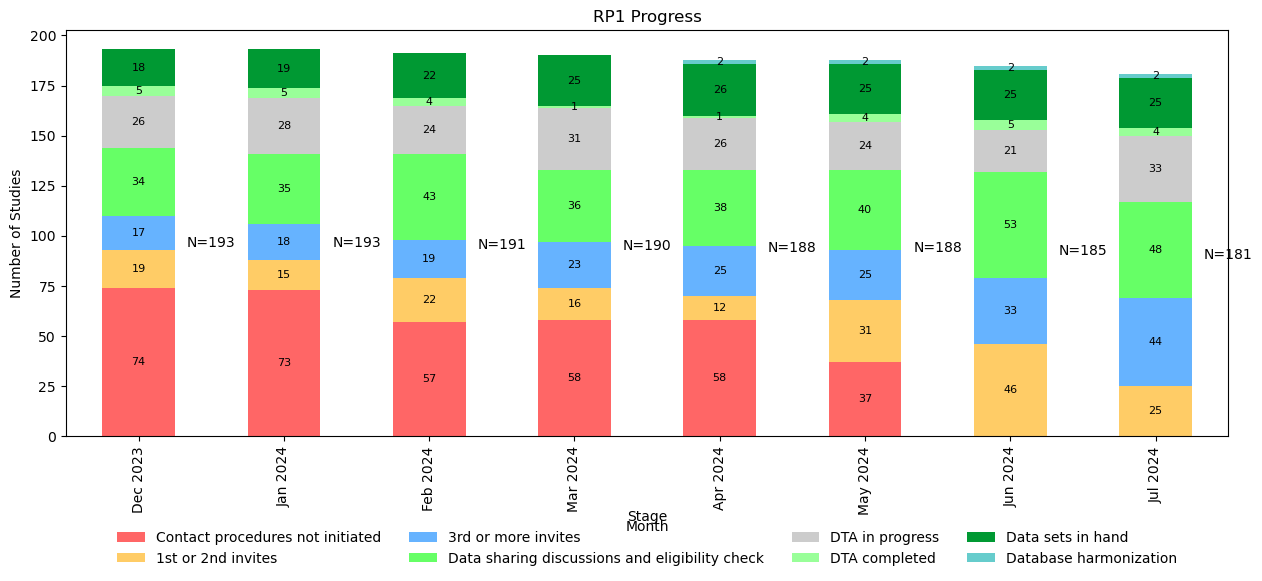

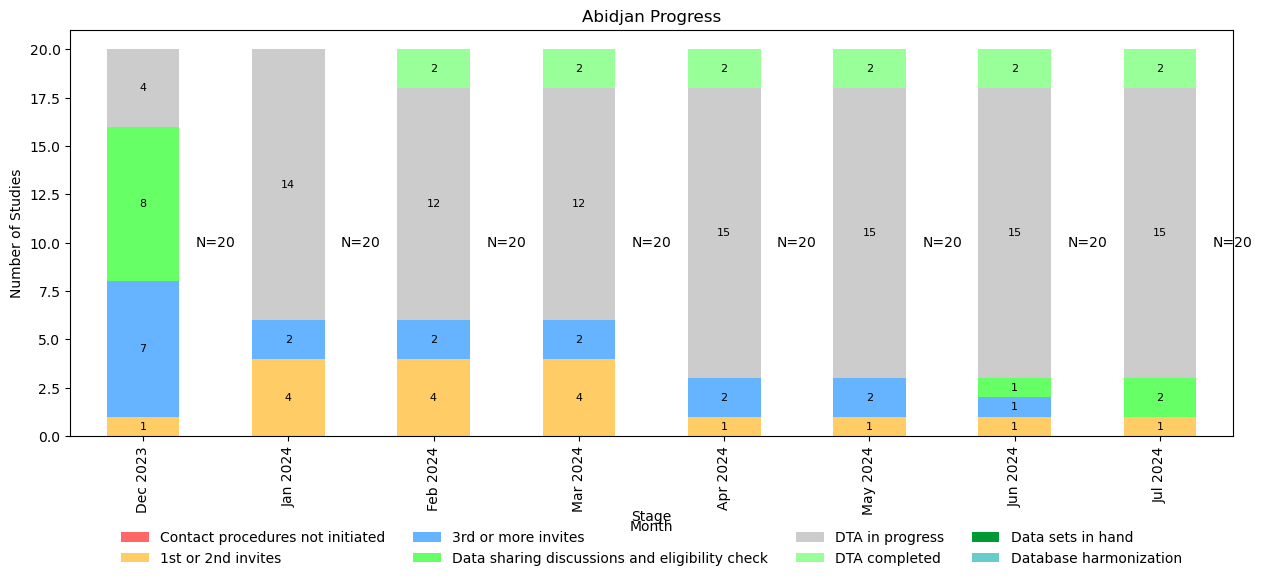

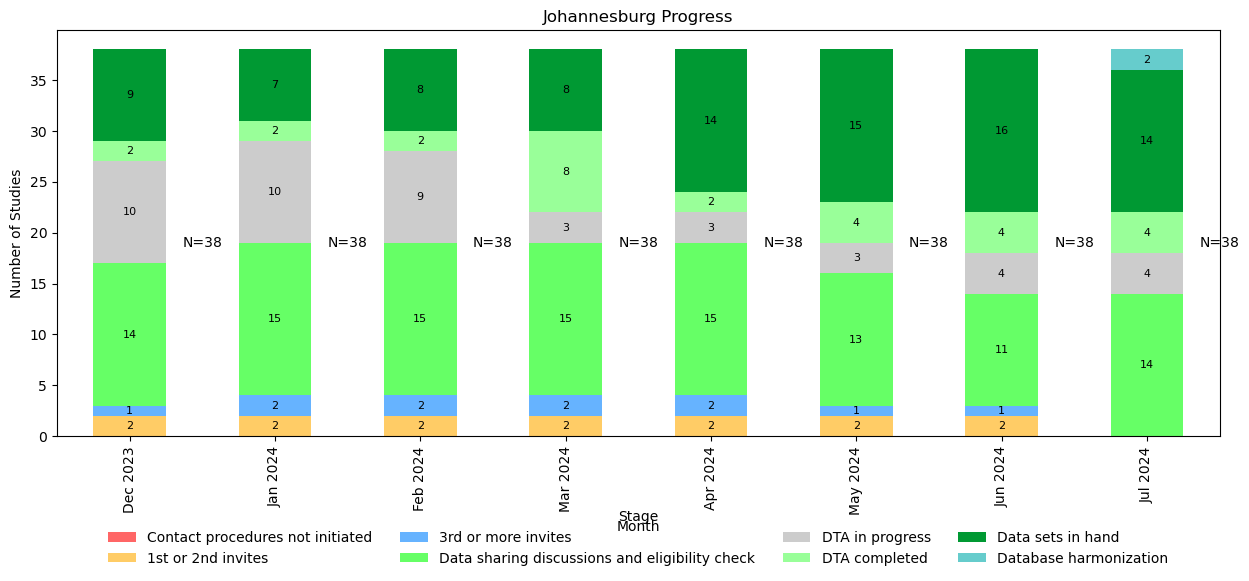

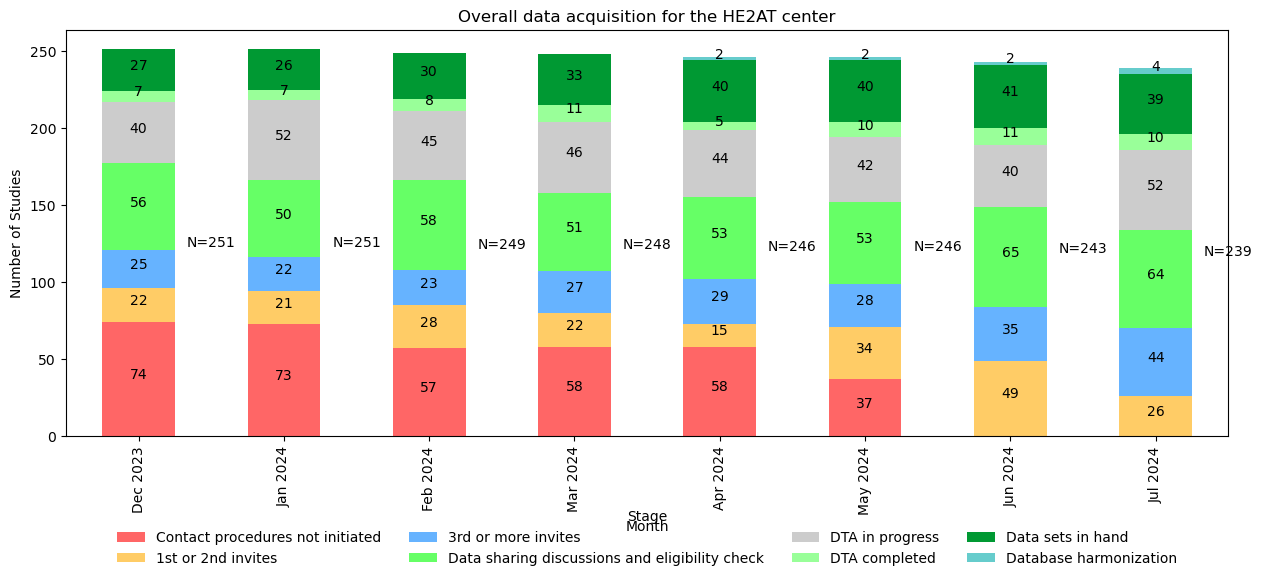

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import os

# Load the Excel file
xlsx_file = pd.read_excel('HEAT_Tables_0517_am.xlsx', sheet_name=['RP1', 'Abj_outputs', 'Jhb_outputs'])

# Extract each DataFrame from the dictionary
df_rp1 = xlsx_file['RP1']
df_abj = xlsx_file['Abj_outputs']
df_jhb = xlsx_file['Jhb_outputs']

# Print the data types of each DataFrame
print("Data types in df_rp1:")
print(df_rp1.dtypes)
print("\nData types in df_abj:")
print(df_abj.dtypes)
print("\nData types in df_jhb:")
print(df_jhb.dtypes)

# Function to map months and years to columns
def map_month_year(df, start_year=2023):
    month_map = {}
    encountered_dec = False  # Flag to indicate if we've encountered 'Dec'
    months_in_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for column in df.columns:
        if any(month in column for month in months_in_order):
            base_month_name = ''.join(filter(str.isalpha, column))
            if base_month_name == 'Jan' and encountered_dec:
                start_year += 1
            if base_month_name == 'Dec':
                encountered_dec = True
            month_map[column] = f'{base_month_name} {start_year}'
    return df.rename(columns=month_map)

# Convert the month columns in each DataFrame to a datetime format
df_rp1 = map_month_year(df_rp1)
df_abj = map_month_year(df_abj)
df_jhb = map_month_year(df_jhb)

# Print the new column names to verify the changes
print(df_rp1.columns)
print(df_abj.columns)
print(df_jhb.columns)

# Convert column names to datetime
def convert_column_to_datetime(df):
    new_columns = []
    for col in df.columns:
        if col == 'Stage':
            new_columns.append(col)
        else:
            date_str = col.strip() + ' 1'
            new_columns.append(pd.to_datetime(date_str, format='%b %Y %d', errors='coerce'))
    df.columns = new_columns

# Apply the conversion to each dataframe
for dataframe in [df_rp1, df_abj, df_jhb]:
    convert_column_to_datetime(dataframe)

# Check for unique and common stages
stages_rp1 = set(df_rp1['Stage'].tolist())
stages_abj = set(df_abj['Stage'].tolist())
stages_jhb = set(df_jhb['Stage'].tolist())

unique_to_rp1 = stages_rp1.difference(stages_abj).difference(stages_jhb)
unique_to_abj = stages_abj.difference(stages_rp1).difference(stages_jhb)
unique_to_jhb = stages_jhb.difference(stages_rp1).difference(stages_abj)
common_stages = stages_rp1.intersection(stages_abj).intersection(stages_jhb)

print("Stages unique to df_rp1:", unique_to_rp1)
print("Stages unique to df_abj:", unique_to_abj)
print("Stages unique to df_jhb:", unique_to_jhb)
print("Common stages:", common_stages)

if unique_to_rp1 or unique_to_abj or unique_to_jhb:
    print("There are differences in the stage names across the dataframes.")
else:
    print("All stage names are consistent across the dataframes.")

# Define the color map and stage order
color_map = {
    'Contact procedures not initiated': '#ff6666',  # Red
    '1st or 2nd invites': '#ffcc66',  # Orange
    '3rd or more invites': '#66b3ff',  # Light Blue
    'Data sharing discussions and eligibility check': '#66ff66',  # Light Green
    'DTA in progress': '#cccccc',  # Grey
    'DTA completed': '#99ff99',  # Light Green
    'Data sets in hand': '#009933',  # Dark Green
    'Database harmonization': '#66cccc',  # Teal
    'Ineligible/declined participation/data currently unavailable': '#ff9999'  # Pink
}

stage_order = [
    'Contact procedures not initiated',
    '1st or 2nd invites',
    '3rd or more invites',
    'Data sharing discussions and eligibility check',
    'DTA in progress',
    'DTA completed',
    'Data sets in hand',
    'Database harmonization',
    'Ineligible/declined participation/data currently unavailable'
]

# Function to plot the main stacked bar chart
def plot_stacked_bar_chart(df, title, last_n_months=8, color_map=None, stage_order=None, save_path=None):
    df = df.set_index('Stage').reindex(stage_order).fillna(0).reset_index()
    excluded_df = df[df['Stage'] == 'Ineligible/declined participation/data currently unavailable']
    df = df[df['Stage'] != 'Ineligible/declined participation/data currently unavailable']
    stages_df = df[~df['Stage'].str.contains("Total")]
    transposed_df = stages_df.set_index('Stage').transpose()
    transposed_df = transposed_df.iloc[-last_n_months:]

    fig, ax = plt.subplots(figsize=(15, 7))
    bars = transposed_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(x, '#333333') for x in stage_order])

    for i, month in enumerate(transposed_df.index):
        month_data = transposed_df.loc[month]
        cumulative_height = month_data.sum()
        total_height = month_data.sum()
        x_position = i + 0.5
        ax.text(x_position, cumulative_height / 2, f"N={int(cumulative_height)}", ha='center', va='center')

        for j, (stage, value) in enumerate(month_data.items()):
            if value > 0:
                height = sum(month_data[:j+1]) - (value / 2)
                ax.text(i, height, f'{int(value)}', ha='center', va='center', fontsize=8)

    ax.set_xticklabels([x.strftime('%b %Y') for x in transposed_df.index])
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# Plot for each DataFrame and save the images
output_directory = "HEAT_Tables_July_2024"
os.makedirs(output_directory, exist_ok=True)

plot_stacked_bar_chart(
    df_rp1, 
    'RP1 Progress', 
    last_n_months=8, 
    color_map=color_map, 
    stage_order=stage_order, 
    save_path=os.path.join(output_directory, 'RP1_Progress.png')
)
plot_stacked_bar_chart(
    df_abj, 
    'Abidjan Progress', 
    last_n_months=8, 
    color_map=color_map, 
    stage_order=stage_order, 
    save_path=os.path.join(output_directory, 'Abidjan_Progress.png')
)
plot_stacked_bar_chart(
    df_jhb, 
    'Johannesburg Progress', 
    last_n_months=8, 
    color_map=color_map, 
    stage_order=stage_order, 
    save_path=os.path.join(output_directory, 'Johannesburg_Progress.png')
)

# Function to combine and plot the cumulative stacked bar chart
def plot_cumulative_stacked_bar_chart(dfs, title, last_n_months=8, color_map=None, stage_order=None, save_path=None):
    combined_df = pd.DataFrame()
    for df in dfs:
        df = df.set_index('Stage').reindex(stage_order).reset_index()
        stages_df = df[~df['Stage'].str.contains("Total")]
        stages_df = stages_df[stages_df['Stage'] != 'Ineligible/declined participation/data currently unavailable']  # Exclude this stage
        if combined_df.empty:
            combined_df = stages_df
        else:
            combined_df = combined_df.set_index('Stage').add(stages_df.set_index('Stage'), fill_value=0).reset_index()
    transposed_df = combined_df.set_index('Stage').transpose()
    transposed_df = transposed_df.iloc[-last_n_months:]

    fig, ax = plt.subplots(figsize=(15, 7))
    bars = transposed_df.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(x, '#333333') for x in stage_order if x != 'Ineligible/declined participation/data currently unavailable'])

    for bar in bars.containers:
        labels = [f'{v.get_height():.0f}' if v.get_height() != 0 else '' for v in bar]
        ax.bar_label(bar, labels=labels, label_type='center', padding=3)

    for i, month in enumerate(transposed_df.index):
        month_data = transposed_df.loc[month]
        cumulative_height = float(month_data.sum())

        x_position = i + 0.5
        ax.text(x_position, cumulative_height / 2, f"N={cumulative_height:.0f}", ha='center', va='center')

    ax.set_xticklabels([x.strftime('%b %Y') for x in transposed_df.index])
    ax.legend(title='Stage', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(stage_order)//2, frameon=False)
    plt.subplots_adjust(bottom=0.3)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Studies')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# Plot the cumulative graph and save the image
plot_cumulative_stacked_bar_chart(
    [df_rp1, df_abj, df_jhb],
    'Overall data acquisition for the HE2AT center',
    last_n_months=8,
    color_map=color_map,
    stage_order=stage_order,
    save_path=os.path.join(output_directory, 'Overall_Progress.png')
)
